Setup & Configuration

In [ ]:
# Setup & Configuration
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
import json
import os
import joblib
from pathlib import Path
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Configuration
class Config:
    # File paths
    RAW_DATA_PATH = "data/raw_conversation.xlsx"
    PROCESSED_DATA_PATH = "data/processed/conversations.pkl"
    MODEL_SAVE_PATH = "models/"
    
    # ML Configuration
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    # Time thresholds (dalam menit)
    NORMAL_THRESHOLD = 5
    SERIOUS_FIRST_REPLY_THRESHOLD = 5
    SERIOUS_FINAL_REPLY_THRESHOLD = 480  # 8 jam
    COMPLAINT_FINAL_REPLY_THRESHOLD = 7200  # 5 hari
    
    # Abandoned detection
    ABANDONED_TIMEOUT_MINUTES = 60  # 1 jam tanpa response
    NO_CONVERSATION_TIMEOUT_MINUTES = 30  # 30 menit tanpa meaningful interaction
    
config = Config()

# Create directories
Path("data/processed").mkdir(parents=True, exist_ok=True)
Path("models").mkdir(exist_ok=True)
Path("output").mkdir(exist_ok=True)
Path("output/reports").mkdir(parents=True, exist_ok=True)
Path("output/visualizations").mkdir(parents=True, exist_ok=True)

print("✅ Setup completed!")

Data Preprocessor

In [ ]:
# Data Preprocessor
class DataPreprocessor:
    def __init__(self):
        self.role_mapping = {
            'bot': 'Bot',
            'customer': 'Customer', 
            'operator': 'Operator',
            'ticket automation': 'Ticket Automation'
        }
    
    def load_raw_data(self, file_path):
        """Load data dari Excel dengan format yang ditentukan"""
        print(f"📖 Loading data from {file_path}")
        
        try:
            df = pd.read_excel(file_path)
            print(f"✅ Loaded {len(df)} rows")
            
            # Validasi columns
            required_columns = ['No', 'Ticket Number', 'Role', 'Sender', 'Message Date', 'Message']
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                print(f"⚠️ Missing columns: {missing_columns}")
                return None
            
            # Clean data
            df = self.clean_data(df)
            return df
            
        except Exception as e:
            print(f"❌ Error loading data: {e}")
            return None
    
    def clean_data(self, df):
        """Clean dan preprocess data"""
        # Copy dataframe
        df_clean = df.copy()
        
        # Handle missing values
        df_clean = df_clean.dropna(subset=['Message', 'Ticket Number'])
        
        # Clean text
        df_clean['Message'] = df_clean['Message'].astype(str).str.strip()
        
        # Parse timestamp
        df_clean['parsed_timestamp'] = pd.to_datetime(
            df_clean['Message Date'], errors='coerce'
        )
        
        # Remove invalid timestamps
        initial_count = len(df_clean)
        df_clean = df_clean[df_clean['parsed_timestamp'].notna()]
        final_count = len(df_clean)
        print(f"📅 Valid timestamps: {final_count}/{initial_count}")
        
        # Standardize roles
        df_clean['Role'] = df_clean['Role'].str.lower().map(
            lambda x: self.role_mapping.get(x, x.title())
        )
        
        # Filter meaningful messages
        df_clean = df_clean[df_clean['Message'].str.len() > 1]
        
        print(f"🧹 Cleaned data: {len(df_clean)} rows")
        return df_clean
    
    def detect_conversation_start(self, ticket_df):
        """Deteksi kapan conversation benar-benar dimulai dengan operator"""
        operator_greeting_patterns = [
            r"halo bapak/ibu.*selamat datang di livechat.*saya.*akan membantu",
            r"Selamat datang di livechat",
            r"Selamat.*, .* Selamat datang di layanan Live Chat Toyota Astra Motor. Dengan .*, apakah ada yang bisa dibantu?",
            r"hai.*selamat datang",
            r"halo.*selamat datang"
        ]
        
        for idx, row in ticket_df.iterrows():
            message = str(row['Message']).lower()
            role = str(row['Role']).lower()
            
            # Cari pattern greeting operator
            if 'operator' in role:
                for pattern in operator_greeting_patterns:
                    if re.search(pattern, message):
                        return row['parsed_timestamp']
        
        return None

# Test preprocessor
preprocessor = DataPreprocessor()
raw_df = preprocessor.load_raw_data(config.RAW_DATA_PATH)

if raw_df is not None:
    print(f"📊 Data preview:")
    print(f"   Columns: {list(raw_df.columns)}")
    print(f"   Shape: {raw_df.shape}")
    print(f"   Ticket count: {raw_df['Ticket Number'].nunique()}")

Conversation Parser & Q-A Pair Detection

In [ ]:
# ===== CONVERSATION PARSER - FIXED VERSION =====
class ConversationParser:
    def __init__(self):
        self.question_indicators = [
            '?', 'apa', 'bagaimana', 'berapa', 'kapan', 'dimana', 'kenapa',
            'bisa', 'boleh', 'minta', 'tolong', 'tanya', 'info', 'caranya',
            'mau tanya', 'boleh tanya', 'minta info', 'berapa harga',
            'bagaimana cara', 'bisa tolong', 'mohon bantuan', 'gimana',
            'promo', 'error', 'rusak', 'masalah', 'mogok', 'gagal', 'tidak bisa',
            'harga', 'biaya', 'tarif', 'fungsi', 'cara', 'solusi', 'bantuan'
        ]
        
        self.operator_greeting_patterns = [
            r"selamat\s+(pagi|siang|sore|malam)",
            r"selamat\s+\w+\s+selamat\s+datang",
            r"selamat\s+datang",
            r"dengan\s+\w+\s+apakah\s+ada",
            r"ada\s+yang\s+bisa\s+dibantu",
            r"boleh\s+dibantu",
            r"bisa\s+dibantu", 
            r"halo.*selamat",
            r"hai.*selamat",
            r"perkenalkan.*saya",
            r"layanan\s+live\s+chat",
            r"live\s+chat\s+toyota",
            r"toyota\s+astra\s+motor"
        ]
        
        self.bot_patterns = [
            'klik.*setuju', 'data privasi', 'virtual assistant', 'silakan memilih',
            'pilih menu', 'silahkan ketik nama', 'halo kak', 'bucket', 'media-images',
            'pusat bantuan', 'main menu', 'feedback'
        ]
        
        self.generic_reply_patterns = [
            'terima kasih telah menghubungi',
            'silakan pilih menu',
            'virtual assistant',
            'akan segera menghubungi',
            'dalam antrian',
            'tunggu sebentar',
            'terima kasih, saat ini anda masuk',
            'customer service akan',
            'menghubungi anda'
        ]
    
    def detect_conversation_start(self, ticket_df):
        """Deteksi kapan conversation benar-benar dimulai dengan operator"""
        ticket_df = ticket_df.sort_values('parsed_timestamp').reset_index(drop=True)
        
        print(f"   🔍 Analyzing {len(ticket_df)} messages for conversation start...")
        
        # METHOD 1: Cari operator greeting message
        for idx, row in ticket_df.iterrows():
            message = str(row['Message']).lower()
            role = str(row['Role']).lower()
            
            if self._is_bot_message(message, role):
                continue
                
            if any(keyword in role for keyword in ['operator', 'agent', 'admin', 'cs']):
                for pattern in self.operator_greeting_patterns:
                    if re.search(pattern, message, re.IGNORECASE):
                        print(f"   ✅ Conversation start: operator greeting at position {idx}")
                        return row['parsed_timestamp']
        
        # METHOD 2: Cari first operator response to meaningful customer question
        meaningful_questions = []
        for idx, row in ticket_df.iterrows():
            role = str(row['Role']).lower()
            message = str(row['Message']).lower()
            
            if self._is_bot_message(message, role):
                continue
                
            if any(keyword in role for keyword in ['customer', 'user', 'pelanggan']):
                if self._is_meaningful_message(message):
                    meaningful_questions.append({
                        'index': idx, 'time': row['parsed_timestamp'], 'message': message
                    })
            
            elif meaningful_questions and any(keyword in role for keyword in ['operator', 'agent']):
                last_question = meaningful_questions[-1]
                time_gap = (row['parsed_timestamp'] - last_question['time']).total_seconds()
                
                if time_gap < 1800:  # 30 menit
                    print(f"   ✅ Conversation start: first operator response at position {idx}")
                    return last_question['time']
        
        # Fallback methods
        if meaningful_questions:
            print(f"   ⚠️  Conversation start: first meaningful question")
            return meaningful_questions[0]['time']
            
        for idx, row in ticket_df.iterrows():
            message = str(row['Message']).lower()
            role = str(row['Role']).lower()
            
            if not self._is_bot_message(message, role):
                print(f"   ⚠️  Conversation start: first non-bot message")
                return row['parsed_timestamp']
        
        if len(ticket_df) > 0:
            print(f"   ⚠️  Conversation start: first message")
            return ticket_df.iloc[0]['parsed_timestamp']
        
        print("   ❌ No conversation start detected")
        return None
    
    def parse_conversation(self, ticket_df):
        """Parse conversation menjadi Q-A pairs - FIXED SORTING VERSION"""
        conversation_start = self.detect_conversation_start(ticket_df)
        
        if not conversation_start:
            print("   ⚠️  Using all non-bot messages")
            conv_df = self._filter_bot_messages(ticket_df)
        else:
            conv_df = self._filter_bot_messages(ticket_df)
            conv_df = conv_df[conv_df['parsed_timestamp'] >= conversation_start]
        
        print(f"   📝 Analyzing {len(conv_df)} meaningful messages")
        
        if len(conv_df) == 0:
            print("   ❌ No meaningful messages after filtering")
            return []
        
        # 🔥 FIX: URUTKAN DATA BERDASARKAN TIMESTAMP DULU!
        conv_df = conv_df.sort_values('parsed_timestamp').reset_index(drop=True)
        print(f"   🔄 Sorted messages by timestamp")
        
        qa_pairs = []
        current_question = None
        question_time = None
        question_context = []
        last_customer_time = None
        
        # Track position untuk debugging
        message_positions = []
        
        for idx, row in conv_df.iterrows():
            role = str(row['Role']).lower()
            message = str(row['Message'])
            timestamp = row['parsed_timestamp']
            
            message_positions.append({
                'position': idx,
                'time': timestamp,
                'role': role,
                'message': message[:50] + '...' if len(message) > 50 else message
            })
            
            # CUSTOMER MESSAGE
            if any(keyword in role for keyword in ['customer', 'user', 'pelanggan']):
                last_customer_time = timestamp
                
                if self._is_meaningful_message(message):
                    # Jika ada previous question yang belum dijawab, simpan dulu
                    if current_question and question_context:
                        self._save_qa_pair(qa_pairs, question_context, question_time, None, None, position=idx)
                    
                    # Start new question
                    current_question = message
                    question_time = timestamp
                    question_context = [message]
                
                elif current_question and question_context:
                    # Check jika ini bagian dari bubble chat yang sama
                    time_gap = (timestamp - question_time).total_seconds()
                    if time_gap < 300:  # 5 menit
                        question_context.append(message)
                        question_time = timestamp  # Update ke timestamp terakhir
                    else:
                        # Bubble chat baru
                        self._save_qa_pair(qa_pairs, question_context, question_time, None, None, position=idx)
                        current_question = message
                        question_time = timestamp
                        question_context = [message]
            
            # OPERATOR MESSAGE - potential answer
            elif current_question and question_context and any(keyword in role for keyword in ['operator', 'agent', 'admin', 'cs']):
                # Skip jika ini generic reply
                if self._is_generic_reply(message):
                    continue
                
                # Pastikan ini benar-benar jawaban (bukan greeting awal)
                time_gap = (timestamp - question_time).total_seconds()
                
                # 🔥 FIX: JANGAN PAKAI MINIMAL 1 MENIT, PAKAI LOGIKA LEBIH BAIK
                # Cek jika ini operator message pertama setelah customer question
                if time_gap >= 0:  # Boleh 0 atau positif (setelah question)
                    lead_time = time_gap
                    self._save_qa_pair(qa_pairs, question_context, question_time, message, timestamp, role, lead_time, position=idx)
                    
                    # Reset untuk next question
                    current_question = None
                    question_time = None
                    question_context = []
        
        # Handle last question jika ada
        if current_question and question_context:
            self._save_qa_pair(qa_pairs, question_context, question_time, None, None, position=len(conv_df))
        
        # POST-PROCESSING: Cari jawaban untuk unanswered questions
        qa_pairs = self._find_missing_answers(conv_df, qa_pairs)
        
        # 🔥 FIX: URUTKAN Q-A PAIRS BERDASARKAN QUESTION TIME!
        qa_pairs = sorted(qa_pairs, key=lambda x: x['question_time'] if x['question_time'] else pd.Timestamp.min)
        
        # 🔥 FIX: TAMBAHKAN POSITION INDEX YANG BENAR BERDASARKAN URUTAN WAKTU
        for i, pair in enumerate(qa_pairs):
            pair['position'] = i  # Position berdasarkan urutan waktu
        
        print(f"   ✅ Found {len(qa_pairs)} Q-A pairs ({sum(1 for p in qa_pairs if p['is_answered'])} answered)")
        
        # Debug: Print message sequence
        print(f"   🔍 Message sequence (first 5):")
        for msg in message_positions[:5]:
            print(f"      {msg['position']}: {msg['time']} | {msg['role']:15} | {msg['message']}")
        
        return qa_pairs
    
    def _save_qa_pair(self, qa_pairs, question_context, question_time, answer, answer_time, answer_role=None, lead_time=None, position=None):
        """Save Q-A pair ke list - FIXED dengan position"""
        full_question = " | ".join(question_context)
        
        pair_data = {
            'question': full_question,
            'question_time': question_time,
            'bubble_count': len(question_context),
            'is_answered': answer is not None,
            'position': position if position is not None else len(qa_pairs)  # Default position
        }
        
        if answer:
            pair_data.update({
                'answer': answer,
                'answer_time': answer_time,
                'answer_role': answer_role,
                'lead_time_seconds': lead_time,
                'lead_time_minutes': round(lead_time / 60, 2) if lead_time else None,
                'lead_time_hhmmss': self._seconds_to_hhmmss(lead_time) if lead_time else None
            })
        else:
            pair_data.update({
                'answer': 'NO_ANSWER',
                'answer_time': None,
                'answer_role': None,
                'lead_time_seconds': None,
                'lead_time_minutes': None,
                'lead_time_hhmmss': None
            })
        
        qa_pairs.append(pair_data)
    
    def _find_missing_answers(self, conv_df, qa_pairs):
        """Cari jawaban untuk questions yang belum terjawab - FIXED SORTING"""
        answered_pairs = [p for p in qa_pairs if p['is_answered']]
        unanswered_pairs = [p for p in qa_pairs if not p['is_answered']]
        
        if not unanswered_pairs:
            return qa_pairs
        
        # Untuk setiap unanswered question, cari operator message setelahnya
        for i, pair in enumerate(unanswered_pairs):
            question_time = pair['question_time']
            
            # Cari operator messages setelah question time
            subsequent_messages = conv_df[
                (conv_df['parsed_timestamp'] > question_time) &
                (conv_df['Role'].str.lower().str.contains('operator|agent|admin|cs', na=False))
            ].sort_values('parsed_timestamp')  # 🔥 FIX: URUTKAN
            
            if not subsequent_messages.empty:
                # Ambil operator message pertama setelah question
                first_operator_msg = subsequent_messages.iloc[0]
                
                # Skip jika generic reply
                if not self._is_generic_reply(first_operator_msg['Message']):
                    lead_time = (first_operator_msg['parsed_timestamp'] - question_time).total_seconds()
                    
                    # Update pair dengan answer yang ditemukan
                    pair.update({
                        'answer': first_operator_msg['Message'],
                        'answer_time': first_operator_msg['parsed_timestamp'],
                        'answer_role': first_operator_msg['Role'],
                        'lead_time_seconds': lead_time,
                        'lead_time_minutes': round(lead_time / 60, 2),
                        'lead_time_hhmmss': self._seconds_to_hhmmss(lead_time),
                        'is_answered': True
                    })
                    print(f"   🔍 Found missing answer for question {i+1}")
        
        return answered_pairs + unanswered_pairs
    
    def _filter_bot_messages(self, df):
        """Filter out bot messages dari dataframe"""
        return df[~df.apply(
            lambda row: self._is_bot_message(str(row['Message']).lower(), str(row['Role']).lower()), 
            axis=1
        )].copy()
    
    def _is_bot_message(self, message, role):
        """Check jika message dari bot"""
        if any(keyword in role for keyword in ['bot', 'system', 'virtual', 'automation']):
            return True
        return any(pattern in message for pattern in self.bot_patterns)
    
    def _is_meaningful_message(self, message):
        """Check jika message meaningful untuk analysis"""
        if not message or len(message.strip()) < 3:
            return False
            
        message_lower = message.lower().strip()
        
        # Skip very short messages yang cuma greetings/consent
        greetings = ['halo', 'hai', 'hi', 'selamat', 'pagi', 'siang', 'sore', 'malam']
        consent_words = ['setuju', 'consent', 'agree', 'ok', 'oke', 'iya', 'yes']
        menu_words = ['menu', 'pusatbantuan', 'mainmenu', 'kembali', 'others']
        
        words = message_lower.split()
        if len(words) <= 2:
            if any(word in words for word in greetings + consent_words + menu_words):
                return False
        
        # Skip pure consent messages
        if any(word in message_lower for word in consent_words) and len(message_lower) < 10:
            return False
            
        # Skip menu navigation
        if any(word in message_lower for word in menu_words) and len(message_lower) < 15:
            return False
        
        # Question indicators
        has_question_indicator = any(indicator in message_lower for indicator in self.question_indicators)
        has_question_mark = '?' in message_lower
        
        # Meaningful content check
        meaningful_words = [w for w in words if len(w) > 2 and w not in greetings + consent_words + menu_words]
        has_meaningful_content = len(meaningful_words) >= 2
        
        return (has_question_indicator and has_meaningful_content) or has_question_mark or len(meaningful_words) >= 3
    
    def _is_generic_reply(self, message):
        """Skip generic/bot replies"""
        message_lower = str(message).lower()
        return any(pattern in message_lower for pattern in self.generic_reply_patterns)
    
    def _seconds_to_hhmmss(self, seconds):
        """Convert seconds to HH:MM:SS format"""
        try:
            hours = int(seconds // 3600)
            minutes = int((seconds % 3600) // 60)
            seconds = int(seconds % 60)
            return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        except:
            return "00:00:00"

    def _calculate_real_lead_time(self, ticket_data, customer_messages, agent_messages):
        """Calculate REAL lead time dari timestamps - FIXED VERSION"""
        try:
            if 'Message Date' not in ticket_data.columns:
                # Estimate based on message count jika tidak ada timestamp
                if customer_messages and agent_messages:
                    return len(agent_messages) * 5.0  # Estimate 5 minutes per reply
                return 10.0  # Default
            
            # Convert to datetime dengan error handling
            ticket_data = ticket_data.copy()
            
            # Debug: Check original Message Date values
            print(f"DEBUG: Original Message Date sample: {ticket_data['Message Date'].head(3).tolist()}")
            
            # Try different date parsing strategies
            ticket_data['parsed_timestamp'] = pd.to_datetime(
                ticket_data['Message Date'], 
                errors='coerce',
                format='mixed'  # Try multiple formats
            )
            
            # Check for parsing failures
            failed_parses = ticket_data['parsed_timestamp'].isna().sum()
            if failed_parses > 0:
                print(f"⚠️ Failed to parse {failed_parses} timestamps")
                
                # Try alternative parsing
                ticket_data['parsed_timestamp'] = pd.to_datetime(
                    ticket_data['Message Date'], 
                    errors='coerce',
                    dayfirst=True  # Try day-first format
                )
            
            # Drop rows with invalid dates
            valid_data = ticket_data.dropna(subset=['parsed_timestamp'])
            
            if len(valid_data) < 2:
                print("⚠️ Not enough valid timestamps, using fallback")
                return 10.0  # Default jika tidak cukup data
            
            # 🔥 FIX: URUTKAN DATA BERDASARKAN TIMESTAMP!
            valid_data = valid_data.sort_values('parsed_timestamp')
            
            print(f"DEBUG: First message: {valid_data.iloc[0]['parsed_timestamp']}")
            print(f"DEBUG: Last message: {valid_data.iloc[-1]['parsed_timestamp']}")
            
            # Find first customer message time
            customer_messages_times = []
            agent_messages_times = []
            
            for idx, row in valid_data.iterrows():
                role_str = str(row['Role']).lower()
                message_time = row['parsed_timestamp']
                
                if any(keyword in role_str for keyword in ['customer', 'user', 'pelanggan']):
                    customer_messages_times.append(message_time)
                elif any(keyword in role_str for keyword in ['operator', 'agent', 'admin', 'cs']):
                    agent_messages_times.append(message_time)
            
            if not customer_messages_times:
                print("⚠️ No customer messages found")
                return 15.0
            
            if not agent_messages_times:
                print("⚠️ No agent messages found")
                return 15.0
            
            # Ambil timestamp pertama customer dan agent
            first_customer_time = min(customer_messages_times)
            first_agent_time = min(agent_messages_times)
            
            print(f"DEBUG: First customer time: {first_customer_time}")
            print(f"DEBUG: First agent time: {first_agent_time}")
            
            # Validasi: pastikan agent reply setelah customer question
            if first_agent_time > first_customer_time:
                lead_time_minutes = (first_agent_time - first_customer_time).total_seconds() / 60
                print(f"DEBUG: Calculated lead time: {lead_time_minutes} minutes")
                
                # Minimum 1 minute, maksimum reasonable
                lead_time_minutes = max(lead_time_minutes, 1.0)
                lead_time_minutes = min(lead_time_minutes, 1440.0)  # Max 24 jam
                
                return lead_time_minutes
            else:
                # Jika agent reply sebelum customer, ini masalah timestamp
                print(f"⚠️ Timestamp issue: Agent replied before customer question")
                print(f"   Customer: {first_customer_time}, Agent: {first_agent_time}")
                
                # Fallback: cari agent reply pertama SETELAH customer question
                subsequent_agents = [t for t in agent_messages_times if t > first_customer_time]
                if subsequent_agents:
                    first_valid_agent_time = min(subsequent_agents)
                    lead_time_minutes = (first_valid_agent_time - first_customer_time).total_seconds() / 60
                    lead_time_minutes = max(lead_time_minutes, 1.0)
                    print(f"✅ Using subsequent agent reply: {lead_time_minutes} minutes")
                    return lead_time_minutes
                else:
                    # Fallback: estimate based on message order
                    print("⚠️ Using message count fallback")
                    if customer_messages and agent_messages:
                        return len(agent_messages) * 3.0
                    
                return 15.0  # Default fallback
                
        except Exception as e:
            print(f"❌ Lead time calculation error: {e}")
            import traceback
            print(f"Detailed error: {traceback.format_exc()}")
            return 10.0  # Fallback
        

Debugging Helper

In [ ]:
# Detailed analysis untuk problematic tickets
def debug_problematic_tickets():
    """Debug khusus untuk ticket yang bermasalah"""
    if raw_df is None:
        return
    
    problematic_tickets = ['18ea89910d0d8eac44aecca81d779e3a', '9842cd7eee5451283f8430fb83469940']
    
    print("🐛 DETAILED DEBUG FOR PROBLEMATIC TICKETS")
    print("=" * 60)
    
    parser = ConversationParser()
    for ticket_id in problematic_tickets:
        print(f"\n🔍 DEBUG TICKET: {ticket_id}")
        ticket_df = raw_df[raw_df['Ticket Number'] == ticket_id].sort_values('parsed_timestamp')
        
        # Show ALL messages setelah conversation start
        conversation_start = parser.detect_conversation_start(ticket_df)
        
        if conversation_start:
            filtered_df = parser._filter_bot_messages(ticket_df)
            filtered_df = filtered_df[filtered_df['parsed_timestamp'] >= conversation_start]
            
            print(f"📋 ALL MESSAGES AFTER CONVERSATION START ({len(filtered_df)} messages):")
            for idx, row in filtered_df.iterrows():
                role = row['Role']
                message = str(row['Message'])[:80]
                timestamp = row['parsed_timestamp']
                is_meaningful = parser._is_meaningful_message(message)
                meaningful_flag = "✅" if is_meaningful else "❌"
                
                print(f"   {meaningful_flag} {timestamp} | {role:15} | {message}...")
            
            # Analyze why no Q-A pairs
            print(f"\n🔎 ANALYSIS:")
            customer_msgs = filtered_df[filtered_df['Role'].str.lower().str.contains('customer', na=False)]
            operator_msgs = filtered_df[filtered_df['Role'].str.lower().str.contains('operator|agent', na=False)]
            
            print(f"   • Customer messages: {len(customer_msgs)}")
            print(f"   • Operator messages: {len(operator_msgs)}")
            
            meaningful_customer = [msg for msg in customer_msgs['Message'] if parser._is_meaningful_message(str(msg))]
            print(f"   • Meaningful customer messages: {len(meaningful_customer)}")
            
            if len(meaningful_customer) == 0:
                print("   ❌ REASON: No meaningful customer questions after operator greeting")
            elif len(operator_msgs) == 0:
                print("   ❌ REASON: No operator responses after customer questions")
            else:
                print("   ❌ REASON: Timing/sequence issues in Q-A matching")

# Run debug
debug_problematic_tickets()

Main Issue Detector

In [ ]:
# Main Issue Detector dengan Enhanced Question Detection
class MainIssueDetector:
    def __init__(self):
        self.issue_keywords = {
            'serious': [
                'error', 'rusak', 'masalah', 'gagal', 'mogok', 'mati', 'tidak bisa', 
                'help', 'urgent', 'kendala', 'trouble', 'macet', 'hang', 'blank',
                'not responding', 'bermasalah', 'gangguan', 'mogok', 'starter',
                'rem blong', 'overheating', 'transmisi', 'kelistrikan', 'aki soak'
            ],
            'complaint': [
                'komplain', 'kecewa', 'marah', 'protes', 'pengaduan', 'keluhan', 
                'sakit hati', 'tidak puas', 'keberatan', 'sangat kecewa', 'refund',
                'garansi ditolak', 'pelayanan buruk', 'tidak profesional'
            ],
            'normal': [
                'tanya', 'info', 'harga', 'berapa', 'cara', 'bagaimana', 'fungsi', 
                'promo', 'spesifikasi', 'fitur', 'mau tanya', 'boleh tanya', 
                'minta info', 'informasi', 'tanyakan', 'booking', 'test drive',
                'alamat', 'lokasi', 'jam operasional', 'servis', 'sparepart'
            ]
        }
        
        # initial question indicators
        self.initial_question_indicators = [
            'mau tanya', 'boleh tanya', 'minta info', 'tanya dong', 'berapa harga',
            'bagaimana cara', 'info', 'promo', 'spesifikasi', 'fungsi',
            'apa', 'bagaimana', 'berapa', 'kapan', 'dimana', 'kenapa',  
            'bisa', 'boleh', 'minta', 'tolong', 'caranya', 'gimana'    
        ]
        
        # follow-up indicators 
        self.follow_up_indicators = [
            'ok', 'oke', 'baik', 'sip', 'terima kasih', 'tks', 'thanks', 'makasih',
            'kalau', 'jadi', 'berarti', 'apakah', 'apakah benar', 'bukan', 'oh',
            'clarification', 'follow up', 'lanjutan' 
        ]
    
    def _is_initial_question(self, question):
        """Improved initial question detection"""
        question_lower = question.lower()
        
        # 1. Check explicit initial question patterns
        if any(indicator in question_lower for indicator in self.initial_question_indicators):
            return True
        
        # 2. Check jika question diawali dengan question word 
        question_words = ['apa', 'bagaimana', 'berapa', 'kapan', 'dimana', 'kenapa', 'bisa', 'boleh']
        first_word = question_lower.split()[0] if question_lower.split() else ""
        if first_word in question_words:
            return True
        
        # 3. Check question mark dan meaningful content 
        has_question_mark = '?' in question_lower
        word_count = len(question_lower.split())
        
        if has_question_mark and word_count >= 4 and not self._is_follow_up(question):
            return True
        
        return False
    
    def _is_follow_up(self, question):
        """Follow-up detection"""
        question_lower = question.lower()
        
        # 1. Check explicit follow-up patterns
        if any(indicator in question_lower for indicator in self.follow_up_indicators):
            return True
        
        # 2. Check jika question pendek dan mengandung acknowledgment
        words = question_lower.split()
        acknowledgment_words = ['ok', 'oke', 'baik', 'sip', 'tks', 'thanks']
        
        if len(words) <= 3 and any(word in acknowledgment_words for word in words):
            return True
        
        # 3. Check clarification patterns
        clarification_indicators = ['berarti', 'jadi', 'bukan', 'oh', 'apakah benar']
        if any(indicator in question_lower for indicator in clarification_indicators):
            return True
        
        return False
    
    def detect_main_issue(self, qa_pairs):
        """Deteksi main issue dari Q-A pairs - IMPROVED"""
        if not qa_pairs:
            return None
        
        scored_issues = []
        
        for i, pair in enumerate(qa_pairs):
            if not pair['is_answered']:
                continue
                
            question = pair['question'].lower()
            score = 0
            
            # 1. Keyword-based scoring 
            complaint_matches = sum(1 for kw in self.issue_keywords['complaint'] if kw in question)
            serious_matches = sum(1 for kw in self.issue_keywords['serious'] if kw in question) 
            normal_matches = sum(1 for kw in self.issue_keywords['normal'] if kw in question)
            
            # Weighted scoring - complaint > serious > normal
            score += (complaint_matches * 3) + (serious_matches * 2) + (normal_matches * 1)
            
            # 2. Question type analysis 
            is_initial_question = self._is_initial_question(pair['question'])  
            is_follow_up = self._is_follow_up(pair['question'])  
            
            if is_initial_question and not is_follow_up:
                score += 3  # Strong bonus untuk initial question
            elif is_follow_up and not is_initial_question:
                score -= 2  # Penalty untuk follow-up/clarification questions
            
            # 3. Position scoring 
            if i == 0:  # First question
                score += 2
            elif i == 1:  # Second question  
                score += 1
            
            # 4. Content quality scoring 
            # Question yang lebih panjang dan detailed biasanya lebih important
            word_count = len(question.split())
            if word_count > 8:
                score += 1
            elif word_count < 4:
                score -= 1
            
            # 5. Lead time consideration 
            # Questions dengan lead time sangat panjang mungkin important
            lead_time = pair.get('lead_time_minutes', 0)
            if lead_time > 15:  # Lebih dari 15 menit
                score += 1
            
            scored_issues.append({
                'question': pair['question'],
                'question_time': pair['question_time'],
                'score': max(score, 0),  
                'position': i,
                'lead_time': lead_time,
                'bubble_count': pair.get('bubble_count', 1),
                'word_count': word_count,
                'is_initial_question': is_initial_question,
                'is_follow_up': is_follow_up,
                'complaint_matches': complaint_matches,
                'serious_matches': serious_matches, 
                'normal_matches': normal_matches,
                'pair_data': pair
            })
        
        if not scored_issues:
            return None
        
        # Pilih question dengan score tertinggi
        main_issue = max(scored_issues, key=lambda x: x['score'])
        
        # IMPROVED issue type determination
        if main_issue['complaint_matches'] > 0:
            issue_type = 'complaint'
        elif main_issue['serious_matches'] > 0:
            issue_type = 'serious'
        elif main_issue['normal_matches'] > 0:
            issue_type = 'normal'
        else:
            # Fallback based on score
            if main_issue['score'] >= 5:
                issue_type = 'complaint'
            elif main_issue['score'] >= 3:
                issue_type = 'serious'
            else:
                issue_type = 'normal'
        
        # Build detailed reason
        reason_parts = []
        if main_issue['is_initial_question']:
            reason_parts.append("initial question")
        if main_issue['complaint_matches'] > 0:
            reason_parts.append(f"{main_issue['complaint_matches']} complaint keywords")
        if main_issue['serious_matches'] > 0:
            reason_parts.append(f"{main_issue['serious_matches']} serious keywords") 
        if main_issue['normal_matches'] > 0:
            reason_parts.append(f"{main_issue['normal_matches']} normal keywords")
        if main_issue['position'] == 0:
            reason_parts.append("first question")
        
        reason = f"Score: {main_issue['score']} ({', '.join(reason_parts)})"
        
        return {
            'question': main_issue['question'],
            'question_time': main_issue['question_time'],
            'issue_type': issue_type,
            'confidence_score': min(main_issue['score'] / 10.0, 1.0),
            'all_candidates': scored_issues,
            'selected_reason': reason,
            'scoring_details': {
                'complaint_matches': main_issue['complaint_matches'],
                'serious_matches': main_issue['serious_matches'],
                'normal_matches': main_issue['normal_matches'],
                'is_initial_question': main_issue['is_initial_question'],
                'is_follow_up': main_issue['is_follow_up']
            }
        }

    def debug_scoring(self, qa_pairs):
        """Debug function untuk melihat detailed scoring"""
        if not qa_pairs:
            return
        
        main_issue = self.detect_main_issue(qa_pairs)
        
        print("🔍 DETAILED SCORING ANALYSIS:")
        print("=" * 60)
        
        for i, candidate in enumerate(main_issue['all_candidates']):
            print(f"\n{i+1}. '{candidate['question'][:60]}...'")
            print(f"   Score: {candidate['score']}")
            print(f"   Position: {candidate['position'] + 1}")
            print(f"   Word Count: {candidate['word_count']}")
            print(f"   Initial Question: {candidate['is_initial_question']}")
            print(f"   Follow-up: {candidate['is_follow_up']}")
            print(f"   Keywords: C:{candidate['complaint_matches']} S:{candidate['serious_matches']} N:{candidate['normal_matches']}")
            print(f"   Lead Time: {candidate['lead_time']} min")

# Test dengan improved detector
detector = MainIssueDetector()

parser = ConversationParser()
if 'parser' in locals() and raw_df is not None:
    sample_ticket_id = 'ead8d44e4914399b76af974a5169856e'
    ticket_df = raw_df[raw_df['Ticket Number'] == sample_ticket_id]
    qa_pairs = parser.parse_conversation(ticket_df)
    
    if qa_pairs:
        print("🎯 ENHANCED MAIN ISSUE DETECTION:")
        main_issue = detector.detect_main_issue(qa_pairs)
        print(f"   Selected: '{main_issue['question'][:80]}...'")
        print(f"   Type: {main_issue['issue_type']}")
        print(f"   Confidence: {main_issue['confidence_score']:.2f}")
        print(f"   Reason: {main_issue['selected_reason']}")
        
        # Show scoring details
        print(f"\n📊 Scoring Details:")
        details = main_issue['scoring_details']
        print(f"   Complaint Keywords: {details['complaint_matches']}")
        print(f"   Serious Keywords: {details['serious_matches']}")
        print(f"   Normal Keywords: {details['normal_matches']}")
        print(f"   Initial Question: {details['is_initial_question']}")
        print(f"   Follow-up: {details['is_follow_up']}")
        
        # Debug scoring
        detector.debug_scoring(qa_pairs)

Hybrid ML Classifier

✅ Hybrid Classifier initialized
🧪 TESTING ENHANCED CLASSIFIER

🔍 Enhanced Prediction Results:
   'mobil saya error tidak bisa starter, mog...' → serious (conf: 0.95)
   'saya komplain tentang pelayanan bengkel ...' → complaint (conf: 0.95)
   'mau tanya harga toyota avanza berapa?...' → normal (conf: 0.95)
   'aplikasi error terus tidak bisa login su...' → serious (conf: 0.95)
   'saya kecewa dengan produk ini, minta ref...' → complaint (conf: 0.95)
   'bagaimana cara aktivasi fitur t-intouch?...' → normal (conf: 0.95)
   'mesin bunyi aneh ada masalah serius...' → serious (conf: 0.95)
   'info promo terbaru untuk innova zenix...' → normal (conf: 0.95)

🤖 CREATING ENHANCED TRAINING DATA...
📊 Enhanced Training Data: 72 samples
📊 Enhanced Test Data: 18 samples
📊 Class Distribution - Train: Counter({'complaint': 24, 'serious': 24, 'normal': 24})
📊 Class Distribution - Test: Counter({'serious': 6, 'complaint': 6, 'normal': 6})
🤖 Training Enhanced ML model...
   Training samples: 72
   Class

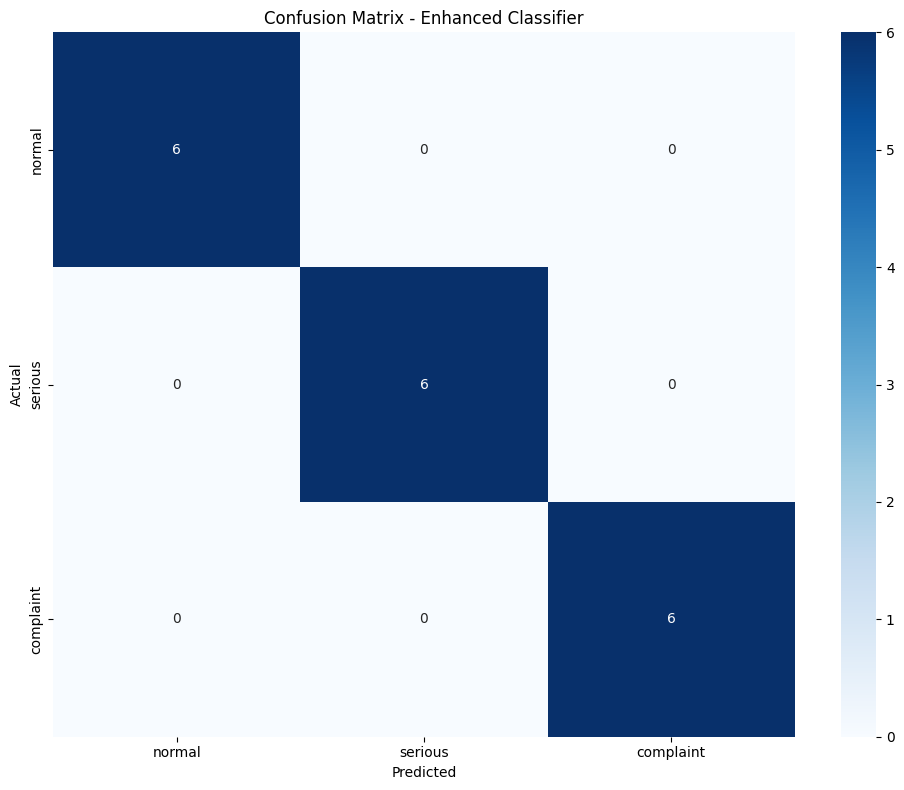


🔍 Top 15 Features per Class:

NORMAL:
   komplain: 1.154
   untuk: 1.083
   dengan: 0.938
   yang: 0.785
   kecewa: 0.750
   pelayanan: 0.659
   protes: 0.588
   sangat: 0.425
   janji: 0.423
   produk: 0.381
   tidak: 0.338
   ditepati: 0.316
   minta: 0.292
   bengkel: 0.282
   biaya: 0.276

SERIOUS:
   berapa: 0.852
   cara: 0.725
   info: 0.646
   avanza: 0.566
   harga: 0.519
   innova: 0.514
   toyota: 0.427
   jam: 0.419
   dealer: 0.404
   dp: 0.366
   berkala: 0.344
   dan: 0.333
   beda: 0.333
   warna: 0.304
   calya: 0.304

COMPLAINT:
   bisa: 0.799
   rem: 0.661
   mesin: 0.609
   terus: 0.590
   jalan: 0.467
   di: 0.426
   tidak: 0.402
   menerus: 0.342
   sama: 0.340
   sekali: 0.340
   tol: 0.331
   tiba: 0.330
   starter: 0.325
   setiap: 0.317
   terbakar: 0.316

✅ ENHANCED HYBRID CLASSIFIER READY!
   Model Accuracy: 1.000
   Training Samples: 72
   Test Samples: 18
   Rule-based Fallback: Active


In [42]:
# Hybrid ML Classifier
class HybridClassifier:
    def __init__(self):
        self.vectorizer = TfidfVectorizer(
            max_features=1000,  # REDUCE features
            ngram_range=(1, 1),  # Start with unigrams saja
            min_df=1,           # Less restrictive
            max_df=0.9,
            stop_words=None     # Jangan remove stop words, penting untuk context
        )
        self.classifier = LogisticRegression(
            random_state=config.RANDOM_STATE,
            max_iter=2000,      # More iterations
            class_weight='balanced',
            C=1.0              # Regularization
        )
        self.is_trained = False
        
        # Enhanced rule-based fallback
        self.rule_keywords = {
            'complaint': [
                'komplain', 'kecewa', 'marah', 'protes', 'pengaduan', 'keluhan', 
                'sakit hati', 'tidak puas', 'keberatan', 'sangat kecewa', 'refund',
                'garansi ditolak', 'pelayanan buruk', 'tidak profesional', 'minta uang kembali'
            ],
            'serious': [
                'error', 'rusak', 'masalah', 'gagal', 'mogok', 'mati', 'tidak bisa', 
                'help', 'urgent', 'kendala', 'trouble', 'macet', 'hang', 'blank',
                'not responding', 'bermasalah', 'gangguan', 'starter', 'rem blong', 
                'overheating', 'transmisi', 'kelistrikan', 'aki soak', 'check engine'
            ],
            'normal': [
                'tanya', 'info', 'harga', 'berapa', 'cara', 'bagaimana', 'fungsi', 
                'promo', 'spesifikasi', 'fitur', 'mau tanya', 'boleh tanya', 
                'minta info', 'informasi', 'tanyakan', 'booking', 'test drive',
                'alamat', 'lokasi', 'jam operasional', 'servis', 'sparepart', 'dp'
            ]
        }
        
        self.high_confidence_threshold = 0.7
        self.medium_confidence_threshold = 0.5
        
        print("✅ Hybrid Classifier initialized")
    
    def create_enhanced_training_data(self):
        """Create BETTER training data dengan lebih banyak samples dan balance"""
        enhanced_data = {
            'texts': [
                "mau tanya harga mobil avanza berapa?",
                "berapa harga toyota rush terbaru?",
                "info promo innova zenix terbaru",
                "bagaimana cara booking test drive?",
                "spesifikasi toyota fortuner lengkap",
                "alamat dealer terdekat di jakarta",
                "jam operasional bengkel toyota",
                "berapa biaya servis berkala avanza?",
                "cara aktivasi fitur t-intouch",
                "fungsi safety sense pada mobil",
                "minta info dp ringan kredit",
                "berapa lama waktu servis berkala?",
                "warna yang tersedia untuk calya",
                "beda innova zenix dan innova lama",
                "fasilitas di bengkel toyota",
                "syarat test drive mobil baru",
                "info asuransi mobil terbaik",
                "cara klaim garansi mobil",
                "berapa harga velg ori innova?",
                "lokasi dealer 24 jam",
                "info cicilan mobil tanpa dp",
                "berapa konsumsi bensin avanza?",
                "sparepart yang perlu diganti rutin",
                "cara perawatan mobil baru",
                "beda vvti dan d4d",
                "berapa harga oli mesin ori?",
                "jadwal service gratis pertama",
                "cara connect android auto",
                "info membership toyota",
                "berapa harga ban mobil avanza",
                
                "mobil saya error tidak bisa starter",
                "mesin bunyi aneh ada masalah serius",
                "aplikasi error terus tidak bisa login",
                "rem blong sangat berbahaya",
                "mogok di jalan butuh bantuan cepat",
                "mesin overheating terus menerus",
                "transmisi bermasalah tidak bisa pindah gigi",
                "kelistrikan error semua lampu mati",
                "aki soak tidak bisa starter pagi ini",
                "check engine menyala terus sejak kemarin",
                "mobil tiba-tiba mati di tol",
                "asap keluar dari kap mesin",
                "rem tidak berfungsi dengan baik",
                "setir berat sekali tidak bisa dibelokkan",
                "oli mesin bocor parah",
                "air radiator habis terus menerus",
                "mobil tidak bisa distarter sama sekali",
                "lampu dashboard berkedip semua",
                "ban pecah di jalan tol",
                "mesin bergetar sangat kencang",
                "kopling slip tidak bisa jalan",
                "ac tidak dingin sama sekali",
                "rem bunyi keras setiap kali diinjak",
                "mobil tidak bisa masuk gigi",
                "asap hitam keluar dari knalpot",
                "mesin sulit dinyakan di pagi hari",
                "rem tangan tidak bisa dilepas",
                "oli terus berkurang setiap hari",
                "mobil terbakar sendiri",
                "kaca spion patah karena kecelakaan",
                
                "saya komplain tentang pelayanan bengkel",
                "sangat kecewa dengan produk toyota ini",
                "komplain untuk garansi yang ditolak",
                "pelayanan customer service sangat buruk",
                "minta refund untuk produk cacat",
                "protes untuk biaya servis yang mahal",
                "pengaduan untuk teknisi tidak profesional",
                "kecewa dengan waiting time yang lama",
                "komplain sparepart palsu yang dipasang",
                "protes untuk janji tidak ditepati",
                "saya marah dengan kualitas servis",
                "komplain mobil baru langsung rusak",
                "kecewa dengan respon yang lambat",
                "minta ganti rugi untuk kerusakan",
                "protes harga sparepart terlalu mahal",
                "komplain untuk janji service tidak tepat waktu",
                "sangat tidak puas dengan pelayanan",
                "komplain mobil sering masuk bengkel",
                "kecewa dengan kualitas cat mobil",
                "protes untuk penanganan yang lamban",
                "komplain untuk informasi yang misleading",
                "saya keberatan dengan biaya tambahan",
                "komplain untuk attitude staff yang kasar",
                "kecewa dengan fitur yang tidak berfungsi",
                "protes untuk kebijakan yang tidak jelas",
                "komplain untuk janji telepon tidak ditepati",
                "sangat marah dengan pelayanan after sales",
                "komplain untuk sparepart tidak tersedia",
                "kecewa dengan waktu tunggu yang panjang",
                "protes untuk solusi yang tidak memuaskan"
            ],
            'labels': ['normal'] * 30 + ['serious'] * 30 + ['complaint'] * 30
        }
        
        return enhanced_data
    
    def train(self, X_train, y_train):
        """Train model dengan enhanced approach"""
        try:
            print("🤖 Training Enhanced ML model...")
            print(f"   Training samples: {len(X_train)}")
            print(f"   Class distribution: {Counter(y_train)}")
            
            # Fit vectorizer dan transform data
            X_vec = self.vectorizer.fit_transform(X_train)
            
            # Train classifier
            self.classifier.fit(X_vec, y_train)
            self.is_trained = True
            
            # Calculate training accuracy
            train_pred = self.classifier.predict(X_vec)
            train_accuracy = accuracy_score(y_train, train_pred)
            
            # Save model
            joblib.dump(self.vectorizer, f"{config.MODEL_SAVE_PATH}/vectorizer.pkl")
            joblib.dump(self.classifier, f"{config.MODEL_SAVE_PATH}/classifier.pkl")
            
            print(f"✅ Model trained - Accuracy: {train_accuracy:.3f}")
            return True
            
        except Exception as e:
            print(f"❌ Training error: {e}")
            return False
    
    def predict(self, text):
        """Predict dengan hybrid approach"""
        if not text or len(text.strip()) < 3:
            return 'normal', 0.5
        
        text_lower = text.lower()
        
        # Step 1: Try ML prediction jika model sudah trained
        ml_prediction, ml_confidence = None, 0.0
        if self.is_trained:
            try:
                X_vec = self.vectorizer.transform([text])
                ml_prediction = self.classifier.predict(X_vec)[0]
                ml_probs = self.classifier.predict_proba(X_vec)[0]
                ml_confidence = np.max(ml_probs)
                
                # High confidence ML prediction
                if ml_confidence >= self.high_confidence_threshold:
                    return ml_prediction, ml_confidence
                    
            except Exception as e:
                print(f"⚠️ ML prediction failed: {e}")
        
        # Step 2: Rule-based prediction
        rule_prediction = self._rule_based_predict(text_lower)
        rule_confidence = self._calculate_rule_confidence(text_lower, rule_prediction)
        
        # Step 3: Hybrid decision making
        if self.is_trained and ml_prediction:
            if ml_confidence >= self.medium_confidence_threshold:
                if ml_prediction == rule_prediction:
                    hybrid_confidence = (ml_confidence + rule_confidence) / 2
                    return ml_prediction, hybrid_confidence
                else:
                    # Conflict - prefer rules untuk safety
                    return rule_prediction, rule_confidence * 0.8
            else:
                return rule_prediction, rule_confidence
        else:
            return rule_prediction, rule_confidence
    
    def _rule_based_predict(self, text_lower):
        """Rule-based classification fallback"""
        scores = {'normal': 0, 'serious': 0, 'complaint': 0}
        
        for category, keywords in self.rule_keywords.items():
            for keyword in keywords:
                if keyword in text_lower:
                    if category == 'complaint':
                        scores[category] += 3
                    elif category == 'serious':
                        scores[category] += 2
                    else:
                        scores[category] += 1
        
        max_score = max(scores.values())
        if max_score == 0:
            return 'normal'
        
        max_categories = [cat for cat, score in scores.items() if score == max_score]
        if len(max_categories) > 1:
            if 'serious' in max_categories:
                return 'serious'
            elif 'complaint' in max_categories:
                return 'complaint'
            else:
                return 'normal'
        
        return max_categories[0]
    
    def _calculate_rule_confidence(self, text_lower, predicted_category):
        """Calculate confidence score untuk rule-based prediction"""
        scores = {'normal': 0, 'serious': 0, 'complaint': 0}
        total_weight = 0
        
        for category, keywords in self.rule_keywords.items():
            for keyword in keywords:
                if keyword in text_lower:
                    weight = 3 if category == 'complaint' else (2 if category == 'serious' else 1)
                    scores[category] += weight
                    total_weight += weight
        
        if total_weight == 0:
            return 0.5
        
        max_score = max(scores.values())
        confidence = max_score / total_weight
        
        sorted_scores = sorted(scores.values(), reverse=True)
        if len(sorted_scores) > 1 and sorted_scores[0] > sorted_scores[1] * 2:
            confidence = min(confidence * 1.2, 0.95)
        
        return confidence
    
    def evaluate_model(self, X_test, y_test):
        """Evaluate model performance dengan detailed report"""
        if not self.is_trained:
            print("❌ Model not trained")
            return None
        
        X_vec = self.vectorizer.transform(X_test)
        y_pred = self.classifier.predict(X_vec)
        y_pred_proba = self.classifier.predict_proba(X_vec)
        
        print("📊 ENHANCED CLASSIFIER PERFORMANCE REPORT")
        print("=" * 50)
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy: {accuracy:.3f}")
        print(f"Test Samples: {len(X_test)}")
        print(f"Class Distribution: {Counter(y_test)}")
        
        print("\n📈 Detailed Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['normal', 'serious', 'complaint']))
        
        max_confidences = np.max(y_pred_proba, axis=1)
        print(f"\n🎯 Confidence Analysis:")
        print(f"   Average Confidence: {np.mean(max_confidences):.3f}")
        print(f"   High Confidence (>0.7): {np.sum(max_confidences > 0.7)}/{len(max_confidences)}")
        print(f"   Low Confidence (<0.5): {np.sum(max_confidences < 0.5)}/{len(max_confidences)}")
        
        # Confusion Matrix
        plt.figure(figsize=(10, 8))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['normal', 'serious', 'complaint'],
                   yticklabels=['normal', 'serious', 'complaint'])
        plt.title('Confusion Matrix - Enhanced Classifier')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.tight_layout()
        plt.show()
        
        # Feature importance
        self._show_feature_importance()
        
        return accuracy
    
    def _show_feature_importance(self, top_n=15):
        """Show most important features untuk setiap class"""
        if not self.is_trained:
            return
        
        feature_names = self.vectorizer.get_feature_names_out()
        
        print(f"\n🔍 Top {top_n} Features per Class:")
        
        for i, class_name in enumerate(['normal', 'serious', 'complaint']):
            coef = self.classifier.coef_[i]
            top_indices = np.argsort(coef)[-top_n:][::-1]
            top_features = [(feature_names[idx], coef[idx]) for idx in top_indices]
            
            print(f"\n{class_name.upper()}:")
            for feature, score in top_features:
                print(f"   {feature}: {score:.3f}")

# Initialize enhanced classifier
classifier = HybridClassifier()

# Test dengan enhanced classifier
print("🧪 TESTING ENHANCED CLASSIFIER")

test_samples = [
    "mobil saya error tidak bisa starter, mogok di jalan",
    "saya komplain tentang pelayanan bengkel yang sangat buruk",
    "mau tanya harga toyota avanza berapa?",
    "aplikasi error terus tidak bisa login sudah 3 hari",
    "saya kecewa dengan produk ini, minta refund",
    "bagaimana cara aktivasi fitur t-intouch?",
    "mesin bunyi aneh ada masalah serius",
    "info promo terbaru untuk innova zenix"
]

print("\n🔍 Enhanced Prediction Results:")
for text in test_samples:
    prediction, confidence = classifier.predict(text)
    print(f"   '{text[:40]}...' → {prediction} (conf: {confidence:.2f})")

# Create ENHANCED training data
print("\n🤖 CREATING ENHANCED TRAINING DATA...")
enhanced_data = classifier.create_enhanced_training_data()

# Split data dengan lebih banyak samples
X_train, X_test, y_train, y_test = train_test_split(
    enhanced_data['texts'], 
    enhanced_data['labels'],
    test_size=0.2,  # 20% test size
    random_state=config.RANDOM_STATE,
    stratify=enhanced_data['labels']
)

print(f"📊 Enhanced Training Data: {len(X_train)} samples")
print(f"📊 Enhanced Test Data: {len(X_test)} samples")
print(f"📊 Class Distribution - Train: {Counter(y_train)}")
print(f"📊 Class Distribution - Test: {Counter(y_test)}")

# Train the enhanced model
success = classifier.train(X_train, y_train)

if success:
    # Evaluate enhanced model
    accuracy = classifier.evaluate_model(X_test, y_test)
    
    print(f"\n✅ ENHANCED HYBRID CLASSIFIER READY!")
    print(f"   Model Accuracy: {accuracy:.3f}")
    print(f"   Training Samples: {len(X_train)}")
    print(f"   Test Samples: {len(X_test)}")
    print(f"   Rule-based Fallback: Active")
else:
    print("❌ Enhanced model training failed, using rule-based only")

Reply Analyzer & Lead Time Calculator (WITH BERT INTEGRATION)

In [43]:
# Reply Analyzer & Lead Time Calculator dengan Enhanced Analysis
class ReplyAnalyzer:
    def __init__(self):
        self.first_reply_indicators = [
            'cek', 'kami teruskan', 'kami diskusikan', 'kami cek dulu', 
            'tunggu sebentar', 'mohon ditunggu', 'akan kami proses',
            'mohon maaf', 'maaf', 'sangat disayangkan', 'kami turut prihatin',
            'bisa diinformasikan', 'bisa dibagikan', 'mohon konfirmasi',
            'bisa dikonfirmasi', 'tolong informasikan', 'sebentar ya',
            'pengecekan', 'verifikasi', 'proses', 'kami bantu'
        ]
        
        self.final_reply_indicators = [
            'bisa menghubungi', 'silakan menghubungi', 'disarankan untuk',
            'berikut informasi', 'nomor telepon', 'alamat dealer', 
            'bengkel resmi', 'jawabannya adalah', 'solusinya', 'bisa dilakukan',
            'prosedurnya', 'caranya', 'merupakan', 'adalah', 'fitur',
            'call center', 'hotline', 'customer service', 'info lengkap',
            'cara mengaktifkan', 'langkah-langkah', 'penjelasan tentang',
            'harga mulai', 'biaya required', 'tarif berlaku', 'jam operasional',
            'alamat lengkap', 'syarat dan ketentuan', 'spesifikasi', 'fungsi',
            'harga', 'biaya', 'tarif', 'promo', 'diskon', 'cara booking'
        ]
        
        self.conversation_enders = [
            'terima kasih', 'thanks', 'makasih', 'tks', 'sampai jumpa',
            'semoga membantu', 'apakah sudah jelas', 'apakah cukup',
            'apakah membantu', 'selamat', 'silahkan', 'sampai bertemu',
            'goodbye', 'bye', 'dadah', 'apakah ada hal lain'
        ]
        
        self.generic_reply_patterns = [
            'terima kasih telah menghubungi',
            'silakan memilih dari menu',
            'virtual assistant', 
            'akan segera menghubungi',
            'dalam antrian',
            'tunggu sebentar',
            'terima kasih, saat ini anda masuk',
            'customer service akan',
            'menghubungi anda',
            'apa lagi yang bisa dibantu',
            'ada yang bisa dibantu'
        ]
        
        # Time thresholds (dalam menit)
        self.time_thresholds = {
            'normal_final': 5,           # 5 menit untuk normal
            'serious_first': 5,          # 5 menit first reply serious
            'serious_final': 480,        # 8 jam final reply serious  
            'complaint_first': 5,        # 5 menit first reply complaint
            'complaint_final': 7200      # 5 hari final reply complaint
        }
    
    def analyze_replies(self, qa_pairs, main_issue_type):
        """Analyze replies berdasarkan issue type dan Q-A pairs - IMPROVED"""
        if not qa_pairs:
            return None, None, self._create_empty_analysis(main_issue_type)
        
        print(f"🔍 Analyzing replies for {main_issue_type} issue...")
        
        # Cari first reply (untuk serious/complaint) dan final reply yang BENERAN meaningful
        first_reply = None
        final_reply = None
        
        if main_issue_type in ['serious', 'complaint']:
            first_reply = self._find_proper_first_reply(qa_pairs)
        
        final_reply = self._find_proper_final_reply(qa_pairs, main_issue_type)
        
        # Jika final reply tidak ditemukan, cari yang paling mendekati
        if not final_reply:
            final_reply = self._find_best_final_reply_candidate(qa_pairs)
        
        # Calculate lead times
        lead_times = self._calculate_lead_times(qa_pairs, first_reply, final_reply, main_issue_type)
        
        # Validate replies
        reply_validation = self._validate_replies(first_reply, final_reply, main_issue_type)
        
        # Performance analysis
        performance_analysis = self._analyze_performance(lead_times, main_issue_type)
        
        analysis_result = {
            'issue_type': main_issue_type,
            'first_reply': first_reply,
            'final_reply': final_reply,
            'lead_times': lead_times,
            'reply_validation': reply_validation,
            'performance_analysis': performance_analysis,
            'threshold_checks': self._check_thresholds(lead_times, main_issue_type),
            'quality_assessment': self._assess_quality(first_reply, final_reply, main_issue_type)
        }
        
        return first_reply, final_reply, analysis_result
    
    def _find_proper_first_reply(self, qa_pairs):
        """Temukan first reply yang meaningful untuk serious/complaint"""
        for pair in qa_pairs:
            if pair['is_answered']:
                answer = pair['answer']
                
                # Skip generic replies dan conversation enders
                if self._is_generic_reply(answer) or self._is_conversation_ender(answer):
                    continue
                
                # Cek first reply indicators
                if any(indicator in answer.lower() for indicator in self.first_reply_indicators):
                    return self._create_reply_object(pair, 'first_proper')
                
                # Atau ambil jawaban pertama yang cukup panjang dan mengandung action
                if len(answer.split()) > 6 and self._contains_action_words(answer):
                    return self._create_reply_object(pair, 'first_action')
        
        return None
    
    def _find_proper_final_reply(self, qa_pairs, issue_type):
        """Temukan final reply yang BENERAN menjawab masalah"""
        meaningful_replies = []
        
        for pair in qa_pairs:
            if pair['is_answered']:
                answer = pair['answer']
                
                # SKIP yang jelas-jelas bukan final answer
                if (self._is_generic_reply(answer) or 
                    self._is_conversation_ender(answer) or
                    self._is_first_reply_type(answer)):
                    continue
                
                # Score berdasarkan seberapa "final" reply ini
                score = 0
                
                # Bonus untuk final reply indicators
                if any(indicator in answer.lower() for indicator in self.final_reply_indicators):
                    score += 3
                
                # Bonus untuk panjang content (lebih comprehensive)
                word_count = len(answer.split())
                if word_count > 10:
                    score += 2
                elif word_count > 5:
                    score += 1
                
                # Bonus untuk mengandung informasi spesifik
                if any(keyword in answer.lower() for keyword in ['nomor', 'alamat', 'harga', 'biaya', 'caranya', 'solusi']):
                    score += 2
                
                # Penalty untuk yang terlalu awal di conversation
                position_penalty = max(0, (len(qa_pairs) - pair.get('position', 0)) / len(qa_pairs) * 2)
                score += position_penalty
                
                if score > 0:
                    meaningful_replies.append({
                        'pair': pair,
                        'score': score,
                        'position': pair.get('position', 0),
                        'word_count': word_count
                    })
        
        if meaningful_replies:
            # Pilih reply dengan score tertinggi
            best_reply = max(meaningful_replies, key=lambda x: x['score'])
            return self._create_reply_object(best_reply['pair'], 'final_proper')
        
        return None
    
    def _find_best_final_reply_candidate(self, qa_pairs):
        """Fallback: cari candidate terbaik untuk final reply"""
        candidates = []
        
        for pair in qa_pairs:
            if pair['is_answered']:
                answer = pair['answer']
                
                # Skip yang jelas bukan final answer
                if self._is_conversation_ender(answer) or self._is_generic_reply(answer):
                    continue
                
                # Score candidate
                score = len(answer.split())  # Basic score berdasarkan length
                
                if any(keyword in answer.lower() for keyword in ['bisa', 'dapat', 'silakan', 'silahkan']):
                    score += 2
                
                candidates.append({
                    'pair': pair,
                    'score': score
                })
        
        if candidates:
            best_candidate = max(candidates, key=lambda x: x['score'])
            return self._create_reply_object(best_candidate['pair'], 'final_fallback')
        
        # Last resort: ambil jawaban terakhir yang bukan ender
        for pair in reversed(qa_pairs):
            if pair['is_answered'] and not self._is_conversation_ender(pair['answer']):
                return self._create_reply_object(pair, 'final_last_resort')
        
        return None
    
    def _contains_action_words(self, message):
        """Cek apakah message mengandung action words"""
        action_words = ['cek', 'proses', 'bantu', 'informasi', 'jelas', 'solusi', 'caranya']
        return any(word in message.lower() for word in action_words)
    
    def _is_first_reply_type(self, message):
        """Cek apakah message lebih cocok sebagai first reply"""
        message_lower = message.lower()
        first_reply_words = ['tunggu', 'sebentar', 'cek', 'proses', 'maaf']
        return any(word in message_lower for word in first_reply_words) and len(message_lower.split()) < 10
    
    def _is_conversation_ender(self, message):
        """Cek apakah message adalah penutup conversation"""
        message_lower = message.lower()
        return any(ender in message_lower for ender in self.conversation_enders)
    
    def _create_reply_object(self, pair, reply_type):
        """Create standardized reply object"""
        return {
            'message': pair['answer'],
            'timestamp': pair['answer_time'],
            'role': pair['answer_role'],
            'reply_type': reply_type,
            'lead_time_seconds': pair.get('lead_time_seconds'),
            'lead_time_minutes': pair.get('lead_time_minutes'),
            'lead_time_hhmmss': pair.get('lead_time_hhmmss'),
            'question': pair['question'],
            'question_time': pair['question_time'],
            'pair_position': pair.get('position', 0)
        }
    
    def _calculate_lead_times(self, qa_pairs, first_reply, final_reply, issue_type):
        """Hitung semua lead times yang relevan - IMPROVED"""
        lead_times = {}
        
        if not qa_pairs or not qa_pairs[0]['is_answered']:
            return lead_times
        
        main_question_time = qa_pairs[0]['question_time']
        
        # Lead time ke first reply (untuk serious/complaint)
        if first_reply and first_reply['timestamp']:
            lead_times['first_reply_lead_time_seconds'] = (
                first_reply['timestamp'] - main_question_time
            ).total_seconds()
            lead_times['first_reply_lead_time_minutes'] = round(
                lead_times['first_reply_lead_time_seconds'] / 60, 2
            )
            lead_times['first_reply_lead_time_hhmmss'] = self._seconds_to_hhmmss(
                lead_times['first_reply_lead_time_seconds']
            )
        
        # Lead time ke final reply
        if final_reply and final_reply['timestamp']:
            lead_times['final_reply_lead_time_seconds'] = (
                final_reply['timestamp'] - main_question_time
            ).total_seconds()
            lead_times['final_reply_lead_time_minutes'] = round(
                lead_times['final_reply_lead_time_seconds'] / 60, 2
            )
            lead_times['final_reply_lead_time_hhmmss'] = self._seconds_to_hhmmss(
                lead_times['final_reply_lead_time_seconds']
            )
        
        # Conversation duration (first to last message)
        if len(qa_pairs) > 1:
            first_time = qa_pairs[0]['question_time']
            last_time = qa_pairs[-1]['answer_time'] if qa_pairs[-1]['is_answered'] else qa_pairs[-1]['question_time']
            
            lead_times['conversation_duration_seconds'] = (last_time - first_time).total_seconds()
            lead_times['conversation_duration_minutes'] = round(
                lead_times['conversation_duration_seconds'] / 60, 2
            )
        
        return lead_times
    
    def _check_thresholds(self, lead_times, issue_type):
        """Check jika lead time melebihi threshold"""
        checks = {}
        
        if issue_type == 'normal':
            if 'final_reply_lead_time_minutes' in lead_times:
                checks['normal_threshold_exceeded'] = (
                    lead_times['final_reply_lead_time_minutes'] > self.time_thresholds['normal_final']
                )
                checks['normal_threshold_minutes'] = self.time_thresholds['normal_final']
                checks['actual_minutes'] = lead_times['final_reply_lead_time_minutes']
        
        elif issue_type == 'serious':
            if 'first_reply_lead_time_minutes' in lead_times:
                checks['serious_first_threshold_exceeded'] = (
                    lead_times['first_reply_lead_time_minutes'] > self.time_thresholds['serious_first']
                )
                checks['serious_first_threshold_minutes'] = self.time_thresholds['serious_first']
                checks['serious_first_actual_minutes'] = lead_times['first_reply_lead_time_minutes']
            
            if 'final_reply_lead_time_minutes' in lead_times:
                checks['serious_final_threshold_exceeded'] = (
                    lead_times['final_reply_lead_time_minutes'] > self.time_thresholds['serious_final']
                )
                checks['serious_final_threshold_minutes'] = self.time_thresholds['serious_final']
                checks['serious_final_actual_minutes'] = lead_times['final_reply_lead_time_minutes']
        
        elif issue_type == 'complaint':
            if 'first_reply_lead_time_minutes' in lead_times:
                checks['complaint_first_threshold_exceeded'] = (
                    lead_times['first_reply_lead_time_minutes'] > self.time_thresholds['complaint_first']
                )
                checks['complaint_first_threshold_minutes'] = self.time_thresholds['complaint_first']
                checks['complaint_first_actual_minutes'] = lead_times['first_reply_lead_time_minutes']
            
            if 'final_reply_lead_time_minutes' in lead_times:
                checks['complaint_final_threshold_exceeded'] = (
                    lead_times['final_reply_lead_time_minutes'] > self.time_thresholds['complaint_final']
                )
                checks['complaint_final_threshold_minutes'] = self.time_thresholds['complaint_final']
                checks['complaint_final_actual_minutes'] = lead_times['final_reply_lead_time_minutes']
        
        return checks
    
    def _validate_replies(self, first_reply, final_reply, issue_type):
        """Validasi kualitas dan kelengkapan replies"""
        validation = {
            'first_reply_found': first_reply is not None,
            'final_reply_found': final_reply is not None,
            'recommendation': '',
            'missing_elements': [],
            'quality_score': 0,
            'quality_rating': 'poor'
        }
        
        # Check untuk serious/complaint issues
        if issue_type in ['serious', 'complaint']:
            if not first_reply:
                validation['missing_elements'].append('first_reply')
                validation['recommendation'] = 'First reply missing for serious/complaint issue'
            elif not self._has_empathy(first_reply['message']):
                validation['missing_elements'].append('empathy_in_first_reply')
        
        if not final_reply:
            validation['missing_elements'].append('final_reply')
            if validation['recommendation']:
                validation['recommendation'] += ' + Final reply missing'
            else:
                validation['recommendation'] = 'Final reply missing'
        elif self._is_conversation_ender(final_reply['message']):
            validation['missing_elements'].append('meaningful_final_reply')
            validation['recommendation'] = 'Final reply is just conversation ender, not meaningful answer'
        
        # Calculate quality score
        score = 0
        if first_reply:
            score += 2
            if self._has_empathy(first_reply['message']):
                score += 1
        if final_reply:
            score += 2
            if self._has_solution(final_reply['message']) and not self._is_conversation_ender(final_reply['message']):
                score += 2
            elif self._has_solution(final_reply['message']):
                score += 1
        
        validation['quality_score'] = score
        validation['quality_rating'] = self._get_quality_rating(score)
        
        if not validation['recommendation'] and score >= 4:
            validation['recommendation'] = 'Replies adequate'
        elif not validation['recommendation']:
            validation['recommendation'] = 'Reply quality needs improvement'
        
        return validation
    
    def _analyze_performance(self, lead_times, issue_type):
        """Analisis performance berdasarkan lead times"""
        performance = {
            'issue_type': issue_type,
            'performance_rating': 'unknown',
            'response_efficiency': 'unknown',
            'resolution_efficiency': 'unknown'
        }
        
        if issue_type == 'normal' and 'final_reply_lead_time_minutes' in lead_times:
            lt = lead_times['final_reply_lead_time_minutes']
            if lt <= 2:
                performance.update({'performance_rating': 'excellent', 'response_efficiency': 'excellent'})
            elif lt <= 5:
                performance.update({'performance_rating': 'good', 'response_efficiency': 'good'})
            elif lt <= 10:
                performance.update({'performance_rating': 'fair', 'response_efficiency': 'fair'})
            else:
                performance.update({'performance_rating': 'poor', 'response_efficiency': 'poor'})
        
        elif issue_type in ['serious', 'complaint']:
            # Evaluate first response
            if 'first_reply_lead_time_minutes' in lead_times:
                lt_first = lead_times['first_reply_lead_time_minutes']
                if lt_first <= 2:
                    performance['response_efficiency'] = 'excellent'
                elif lt_first <= 5:
                    performance['response_efficiency'] = 'good'
                elif lt_first <= 10:
                    performance['response_efficiency'] = 'fair'
                else:
                    performance['response_efficiency'] = 'poor'
            
            # Evaluate final resolution
            if 'final_reply_lead_time_minutes' in lead_times:
                lt_final = lead_times['final_reply_lead_time_minutes']
                max_threshold = self.time_thresholds['serious_final'] if issue_type == 'serious' else self.time_thresholds['complaint_final']
                
                if lt_final <= max_threshold * 0.3:  # Within 30% of threshold
                    performance['resolution_efficiency'] = 'excellent'
                elif lt_final <= max_threshold * 0.6:  # Within 60% of threshold
                    performance['resolution_efficiency'] = 'good'
                elif lt_final <= max_threshold:  # Within threshold
                    performance['resolution_efficiency'] = 'fair'
                else:
                    performance['resolution_efficiency'] = 'poor'
            
            # Overall rating
            if performance['response_efficiency'] in ['excellent', 'good'] and performance['resolution_efficiency'] in ['excellent', 'good']:
                performance['performance_rating'] = 'excellent'
            elif performance['response_efficiency'] in ['excellent', 'good', 'fair'] and performance['resolution_efficiency'] in ['excellent', 'good', 'fair']:
                performance['performance_rating'] = 'good'
            else:
                performance['performance_rating'] = 'poor'
        
        return performance
    
    def _assess_quality(self, first_reply, final_reply, issue_type):
        """Assess kualitas replies"""
        quality = {
            'first_reply_quality': 'unknown',
            'final_reply_quality': 'unknown',
            'overall_quality': 'unknown'
        }
        
        if first_reply:
            quality['first_reply_quality'] = self._assess_reply_quality(first_reply['message'], 'first', issue_type)
        
        if final_reply:
            quality['final_reply_quality'] = self._assess_reply_quality(final_reply['message'], 'final', issue_type)
        
        # Overall quality
        if (quality['first_reply_quality'] in ['excellent', 'good'] and 
            quality['final_reply_quality'] in ['excellent', 'good'] and
            final_reply and not self._is_conversation_ender(final_reply['message'])):
            quality['overall_quality'] = 'excellent'
        elif (quality['first_reply_quality'] in ['excellent', 'good', 'fair'] and 
              quality['final_reply_quality'] in ['excellent', 'good', 'fair']):
            quality['overall_quality'] = 'good'
        else:
            quality['overall_quality'] = 'poor'
        
        return quality
    
    def _assess_reply_quality(self, message, reply_type, issue_type):
        """Assess kualitas individual reply"""
        message_lower = message.lower()
        
        if reply_type == 'first':
            # First reply assessment
            empathy_indicators = ['mohon maaf', 'maaf', 'turut prihatin', 'sangat disayangkan', 'kami turut merasakan']
            action_indicators = ['kami cek', 'kami proses', 'akan kami', 'pengecekan', 'verifikasi', 'kami bantu']
            
            empathy_score = sum(1 for indicator in empathy_indicators if indicator in message_lower)
            action_score = sum(1 for indicator in action_indicators if indicator in message_lower)
            
            if empathy_score >= 1 and action_score >= 1:
                return 'excellent'
            elif empathy_score >= 1 or action_score >= 1:
                return 'good'
            else:
                return 'fair'
        
        else:  # final reply
            # Skip jika cuma conversation ender
            if self._is_conversation_ender(message):
                return 'poor'
                
            # Final reply assessment
            solution_indicators = ['solusi', 'jawaban', 'caranya', 'prosedur', 'bisa menghubungi', 'silakan menghubungi', 'disarankan']
            information_indicators = ['berikut', 'informasi', 'nomor', 'alamat', 'jam', 'kontak', 'harga', 'biaya', 'caranya']
            
            solution_score = sum(1 for indicator in solution_indicators if indicator in message_lower)
            information_score = sum(1 for indicator in information_indicators if indicator in message_lower)
            
            if solution_score >= 1 and information_score >= 2:
                return 'excellent'
            elif solution_score >= 1 or information_score >= 1:
                return 'good'
            else:
                return 'fair'
    
    def _has_empathy(self, message):
        """Cek apakah reply mengandung empathy"""
        empathy_indicators = ['mohon maaf', 'maaf', 'turut prihatin', 'sangat disayangkan', 'kami turut merasakan']
        return any(indicator in message.lower() for indicator in empathy_indicators)
    
    def _has_solution(self, message):
        """Cek apakah reply mengandung solusi"""
        solution_indicators = ['solusi', 'jawaban', 'caranya', 'prosedur', 'bisa menghubungi', 'silakan menghubungi', 'bisa', 'dapat']
        return any(indicator in message.lower() for indicator in solution_indicators)
    
    def _is_generic_reply(self, message):
        """Cek apakah reply generic/template"""
        message_lower = message.lower()
        return any(pattern in message_lower for pattern in self.generic_reply_patterns)
    
    def _get_quality_rating(self, score):
        """Convert quality score ke rating"""
        if score >= 5:
            return 'excellent'
        elif score >= 3:
            return 'good'
        elif score >= 1:
            return 'fair'
        else:
            return 'poor'
    
    def _create_empty_analysis(self, issue_type):
        """Create empty analysis result"""
        return {
            'issue_type': issue_type,
            'lead_times': {},
            'reply_validation': {
                'first_reply_found': False,
                'final_reply_found': False,
                'recommendation': 'No replies analyzed',
                'missing_elements': ['first_reply', 'final_reply'],
                'quality_score': 0,
                'quality_rating': 'poor'
            },
            'performance_analysis': {
                'issue_type': issue_type,
                'performance_rating': 'unknown',
                'response_efficiency': 'unknown',
                'resolution_efficiency': 'unknown'
            },
            'threshold_checks': {},
            'quality_assessment': {
                'first_reply_quality': 'unknown',
                'final_reply_quality': 'unknown',
                'overall_quality': 'poor'
            }
        }
    
    def _seconds_to_hhmmss(self, seconds):
        """Convert seconds to HH:MM:SS format"""
        try:
            hours = int(seconds // 3600)
            minutes = int((seconds % 3600) // 60)
            seconds = int(seconds % 60)
            return f"{hours:02d}:{minutes:02d}:{seconds:02d}"
        except:
            return "00:00:00"

# InitializeReply Analyzer
reply_analyzer = ReplyAnalyzer()

print("✅ PROPERLY FIXED Reply Analyzer & Lead Time Calculator Ready!")
print("=" * 60)

# Test dengan sample data
if 'parser' in locals() and 'detector' in locals() and raw_df is not None:
    sample_ticket_id = 'ead8d44e4914399b76af974a5169856e'
    ticket_df = raw_df[raw_df['Ticket Number'] == sample_ticket_id]
    qa_pairs = parser.parse_conversation(ticket_df)
    
    if qa_pairs:
        print("🧪 TESTING PROPERLY FIXED REPLY ANALYSIS:")
        
        # Detect main issue
        main_issue = detector.detect_main_issue(qa_pairs)
        issue_type = main_issue['issue_type']
        
        print(f"   Main Issue Type: {issue_type}")
        print(f"   Main Question: {main_issue['question'][:80]}...")
        
        # Analyze replies dengan fixed version
        first_reply, final_reply, analysis = reply_analyzer.analyze_replies(qa_pairs, issue_type)
        
        # Display results
        print(f"\n📊 PROPERLY FIXED REPLY ANALYSIS RESULTS:")
        print(f"   First Reply Found: {analysis['reply_validation']['first_reply_found']}")
        print(f"   Final Reply Found: {analysis['reply_validation']['final_reply_found']}")
        print(f"   Quality Rating: {analysis['reply_validation']['quality_rating']}")
        print(f"   Quality Score: {analysis['reply_validation']['quality_score']}")
        print(f"   Recommendation: {analysis['reply_validation']['recommendation']}")
        
        # Lead Times
        if analysis['lead_times']:
            print(f"\n⏱️ LEAD TIMES:")
            for key, value in analysis['lead_times'].items():
                if 'minutes' in key and value is not None:
                    print(f"   {key}: {value}")
        
        # Threshold Checks
        if analysis['threshold_checks']:
            print(f"\n🎯 THRESHOLD CHECKS:")
            for key, value in analysis['threshold_checks'].items():
                if 'exceeded' in key:
                    status = "❌ EXCEEDED" if value else "✅ WITHIN LIMIT"
                    actual = analysis['threshold_checks'].get(f"{key.replace('_exceeded', '_actual_minutes')}", 'N/A')
                    threshold = analysis['threshold_checks'].get(f"{key.replace('_exceeded', '_threshold_minutes')}", 'N/A')
                    print(f"   {key}: {status} ({actual}m vs {threshold}m)")
        
        # Performance Analysis
        perf = analysis['performance_analysis']
        print(f"\n📈 PERFORMANCE ANALYSIS:")
        print(f"   Performance Rating: {perf['performance_rating'].upper()}")
        if 'response_efficiency' in perf:
            print(f"   Response Efficiency: {perf['response_efficiency'].upper()}")
        if 'resolution_efficiency' in perf:
            print(f"   Resolution Efficiency: {perf['resolution_efficiency'].upper()}")
        
        # Quality Assessment
        quality = analysis['quality_assessment']
        print(f"\n⭐ QUALITY ASSESSMENT:")
        print(f"   First Reply Quality: {quality['first_reply_quality'].upper()}")
        print(f"   Final Reply Quality: {quality['final_reply_quality'].upper()}")
        print(f"   Overall Quality: {quality['overall_quality'].upper()}")
        
        # Show actual replies jika ada
        if first_reply:
            print(f"\n🔍 FIRST REPLY:")
            print(f"   Time: {first_reply.get('lead_time_minutes', 'N/A')} minutes")
            print(f"   Type: {first_reply.get('reply_type', 'N/A')}")
            print(f"   Message: {first_reply['message'][:100]}...")
        
        if final_reply:
            print(f"\n🎯 FINAL REPLY:")
            print(f"   Time: {final_reply.get('lead_time_minutes', 'N/A')} minutes") 
            print(f"   Type: {final_reply.get('reply_type', 'N/A')}")
            print(f"   Message: {final_reply['message'][:100]}...")
            if reply_analyzer._is_conversation_ender(final_reply['message']):
                print(f"   ⚠️  WARNING: This appears to be a conversation ender, not a meaningful final answer!")

✅ PROPERLY FIXED Reply Analyzer & Lead Time Calculator Ready!
   🔍 Analyzing 27 messages for conversation start...
   ✅ Conversation start: operator greeting at position 12
   📝 Analyzing 14 meaningful messages
   🔄 Sorted messages by timestamp
   🔍 Found missing answer for question 1
   🔍 Found missing answer for question 2
   ✅ Found 6 Q-A pairs (6 answered)
   🔍 Message sequence (first 5):
      0: 2025-11-01 08:01:08.772000 | operator        | Selamat pagi Ibu Grace. Selamat datang di layanan ...
      1: 2025-11-01 08:02:03.082000 | customer        | Saya mau tanya harga filter solar untuk vrz 2016
      2: 2025-11-01 08:02:21.789000 | customer        | filter bahan bakar beda dgn filter oli
      3: 2025-11-01 08:02:49.326000 | operator        | Baik, Ibu Grace.
      4: 2025-11-01 08:02:57.943000 | customer        | Kalau filter bahan bakar tsb brp lama harus di gan...
🧪 TESTING PROPERLY FIXED REPLY ANALYSIS:
   Main Issue Type: normal
   Main Question: Saya mau tanya harga filt

Complete Analysis Pipeline

In [44]:
# CELL 8 - CompleteAnalysisPipeline (FULL FIX)
import time
from datetime import datetime
from collections import Counter

class CompleteAnalysisPipeline:
    def __init__(self):
        self.preprocessor = DataPreprocessor()
        self.parser = ConversationParser()
        self.issue_detector = MainIssueDetector()
        self.classifier = HybridClassifier()
        self.reply_analyzer = ReplyAnalyzer()
        self.results = []
        self.analysis_stats = {}
        
        print("🚀 Complete Analysis Pipeline Initialized")
        print("   ✓ Data Preprocessor")
        print("   ✓ Conversation Parser") 
        print("   ✓ Main Issue Detector")
        print("   ✓ Hybrid Classifier")
        print("   ✓ Reply Analyzer")
    
    def analyze_single_ticket(self, ticket_df, ticket_id):
        """Analisis lengkap untuk single ticket - SIMPAN SEMUA DATA"""
        print(f"🎯 Analyzing Ticket: {ticket_id}")
        
        try:
            # Step 1: Parse Q-A pairs
            qa_pairs = self.parser.parse_conversation(ticket_df)
            
            if not qa_pairs:
                return self._create_ticket_result(ticket_id, "failed", "No Q-A pairs detected", {})
            
            answered_count = sum(1 for pair in qa_pairs if pair['is_answered'])
            print(f"   ✓ Found {len(qa_pairs)} Q-A pairs ({answered_count} answered)")
            
            # Step 2: Detect main issue
            main_issue = self.issue_detector.detect_main_issue(qa_pairs)
            
            if not main_issue:
                return self._create_ticket_result(ticket_id, "failed", "No main issue detected", {})
            
            print(f"   ✓ Main issue: {main_issue['issue_type']} (conf: {main_issue['confidence_score']:.2f})")
            
            # Step 3: Classify issue type (double-check dengan ML)
            ml_prediction, ml_confidence = self.classifier.predict(main_issue['question'])
            final_issue_type = self._resolve_issue_type(main_issue['issue_type'], ml_prediction, ml_confidence)
            
            print(f"   ✓ Final classification: {final_issue_type} (ML conf: {ml_confidence:.2f})")
            
            # Step 4: Analyze replies and lead times
            first_reply, final_reply, reply_analysis = self.reply_analyzer.analyze_replies(
                qa_pairs, final_issue_type
            )
            
            # Step 5: Compile COMPREHENSIVE results dengan SEMUA DATA
            result = {
                'ticket_id': ticket_id,
                'status': 'success',
                'analysis_timestamp': datetime.now(),
                
                # Conversation info
                'total_messages': len(ticket_df),
                'total_qa_pairs': len(qa_pairs),
                'answered_pairs': answered_count,
                'conversation_duration_minutes': reply_analysis.get('lead_times', {}).get('conversation_duration_minutes', 0),
                
                # Main issue analysis - LENGKAP
                'main_question': main_issue['question'],
                'main_question_time': main_issue['question_time'],
                'detected_issue_type': main_issue['issue_type'],
                'detection_confidence': main_issue['confidence_score'],
                'final_issue_type': final_issue_type,
                'ml_prediction': ml_prediction,
                'ml_confidence': ml_confidence,
                'main_issue_reason': main_issue['selected_reason'],
                
                # Reply analysis - LENGKAP
                'first_reply_found': reply_analysis['reply_validation']['first_reply_found'],
                'final_reply_found': reply_analysis['reply_validation']['final_reply_found'],
                'first_reply_message': first_reply['message'] if first_reply else None,
                'first_reply_time': first_reply['timestamp'] if first_reply else None,
                'final_reply_message': final_reply['message'] if final_reply else None,
                'final_reply_time': final_reply['timestamp'] if final_reply else None,
                
                # Lead times - LENGKAP
                'first_reply_lead_time_minutes': reply_analysis['lead_times'].get('first_reply_lead_time_minutes'),
                'final_reply_lead_time_minutes': reply_analysis['lead_times'].get('final_reply_lead_time_minutes'),
                'first_reply_lead_time_hhmmss': reply_analysis['lead_times'].get('first_reply_lead_time_hhmmss'),
                'final_reply_lead_time_hhmmss': reply_analysis['lead_times'].get('final_reply_lead_time_hhmmss'),
                
                # Performance metrics
                'performance_rating': reply_analysis['performance_analysis']['performance_rating'],
                'response_efficiency': reply_analysis['performance_analysis'].get('response_efficiency', 'unknown'),
                'resolution_efficiency': reply_analysis['performance_analysis'].get('resolution_efficiency', 'unknown'),
                'quality_rating': reply_analysis['reply_validation']['quality_rating'],
                'quality_score': reply_analysis['reply_validation']['quality_score'],
                
                # Threshold checks
                'threshold_violations': self._extract_threshold_violations(reply_analysis['threshold_checks']),
                
                # Recommendations
                'recommendation': reply_analysis['reply_validation']['recommendation'],
                'missing_elements': reply_analysis['reply_validation']['missing_elements'],
                
                # ✅✅✅ RAW DATA LENGKAP UNTUK EXPORT ✅✅✅
                '_raw_qa_pairs': qa_pairs,                    # SEMUA Q-A PAIRS
                '_raw_main_issue': main_issue,                # DETAIL MAIN ISSUE
                '_raw_reply_analysis': reply_analysis         # DETAIL REPLY ANALYSIS
            }
            
            print(f"   ✅ Analysis completed - Performance: {result['performance_rating'].upper()}")
            return result
            
        except Exception as e:
            error_msg = f"Error: {str(e)}"
            print(f"   ❌ Analysis failed: {error_msg}")
            return self._create_ticket_result(ticket_id, "failed", error_msg, {})
    
    def _resolve_issue_type(self, detected_type, ml_prediction, ml_confidence):
        """Resolve final issue type antara rule-based dan ML"""
        if ml_confidence > 0.7:  # High confidence ML
            return ml_prediction
        elif ml_confidence > 0.5 and ml_prediction == detected_type:  # Consistent
            return ml_prediction
        else:  # Trust rule-based detection
            return detected_type
    
    def _extract_threshold_violations(self, threshold_checks):
        """Extract threshold violations dari analysis"""
        violations = []
        for key, value in threshold_checks.items():
            if 'exceeded' in key and value:
                violations.append(key)
        return violations
    
    def _create_ticket_result(self, ticket_id, status, reason, extra_data):
        """Create standardized result object"""
        result = {
            'ticket_id': ticket_id,
            'status': status,
            'failure_reason': reason if status == 'failed' else None,
            'analysis_timestamp': datetime.now()
        }
        result.update(extra_data)
        return result
    
    def analyze_all_tickets(self, df, sample_size=None, max_tickets=None):
        """Analisis semua tickets dengan comprehensive reporting"""
        print("🚀 STARTING COMPLETE ANALYSIS PIPELINE")
        print("=" * 60)
        
        ticket_ids = df['Ticket Number'].unique()
        
        if sample_size:
            ticket_ids = ticket_ids[:sample_size]
            print(f"🔍 Analyzing {sample_size} sample tickets...")
        elif max_tickets:
            ticket_ids = ticket_ids[:max_tickets]
            print(f"🔍 Analyzing {max_tickets} tickets (max limit)...")
        else:
            print(f"🔍 Analyzing {len(ticket_ids)} tickets...")
        
        self.results = []
        successful_analyses = 0
        
        start_time = time.time()
        
        for i, ticket_id in enumerate(ticket_ids):
            ticket_df = df[df['Ticket Number'] == ticket_id]
            
            result = self.analyze_single_ticket(ticket_df, ticket_id)
            self.results.append(result)
            
            if result['status'] == 'success':
                successful_analyses += 1
            
            # Progress reporting
            if (i + 1) % 10 == 0 or (i + 1) == len(ticket_ids):
                progress = (i + 1) / len(ticket_ids) * 100
                print(f"   📊 Progress: {i + 1}/{len(ticket_ids)} ({progress:.1f}%) - {successful_analyses} successful")
        
        # Calculate comprehensive statistics
        analysis_time = time.time() - start_time
        self.analysis_stats = self._calculate_comprehensive_stats(analysis_time)
        
        print(f"\n🎉 ANALYSIS PIPELINE COMPLETED!")
        print("=" * 60)
        self._print_summary_report()
        
        return self.results, self.analysis_stats
    
    def _calculate_comprehensive_stats(self, analysis_time):
        """Hitung comprehensive statistics dari results"""
        successful = [r for r in self.results if r['status'] == 'success']
        failed = [r for r in self.results if r['status'] == 'failed']
        
        if not successful:
            return {
                'total_tickets': len(self.results),
                'successful_analysis': 0,
                'failed_analysis': len(failed),
                'success_rate': 0,
                'analysis_duration_seconds': analysis_time
            }
        
        # Basic stats
        stats = {
            'total_tickets': len(self.results),
            'successful_analysis': len(successful),
            'failed_analysis': len(failed),
            'success_rate': len(successful) / len(self.results),
            'analysis_duration_seconds': analysis_time,
            'avg_analysis_time_per_ticket': analysis_time / len(self.results)
        }
        
        # Issue type distribution
        issue_types = [r['final_issue_type'] for r in successful]
        stats['issue_type_distribution'] = dict(Counter(issue_types))
        
        # Performance metrics
        performance_ratings = [r['performance_rating'] for r in successful]
        stats['performance_distribution'] = dict(Counter(performance_ratings))
        
        # Lead time statistics
        lead_times = [r['final_reply_lead_time_minutes'] for r in successful if r['final_reply_lead_time_minutes'] is not None]
        if lead_times:
            stats['lead_time_stats'] = {
                'avg_lead_time_minutes': np.mean(lead_times),
                'median_lead_time_minutes': np.median(lead_times),
                'min_lead_time_minutes': np.min(lead_times),
                'max_lead_time_minutes': np.max(lead_times),
                'std_lead_time_minutes': np.std(lead_times)
            }
        
        # Quality metrics
        quality_scores = [r['quality_score'] for r in successful]
        stats['quality_stats'] = {
            'avg_quality_score': np.mean(quality_scores),
            'avg_quality_rating': Counter([r['quality_rating'] for r in successful]).most_common(1)[0][0]
        }
        
        # Threshold violations
        all_violations = []
        for r in successful:
            all_violations.extend(r.get('threshold_violations', []))
        stats['threshold_violations'] = dict(Counter(all_violations))
        
        # Reply effectiveness
        stats['reply_effectiveness'] = {
            'first_reply_found_rate': sum(1 for r in successful if r['first_reply_found']) / len(successful),
            'final_reply_found_rate': sum(1 for r in successful if r['final_reply_found']) / len(successful),
            'both_replies_found_rate': sum(1 for r in successful if r['first_reply_found'] and r['final_reply_found']) / len(successful)
        }

        # Q-A Pairs Statistics
        total_qa_pairs = sum(r['total_qa_pairs'] for r in successful)
        total_answered_pairs = sum(r['answered_pairs'] for r in successful)
        stats['qa_pairs_stats'] = {
            'total_qa_pairs': total_qa_pairs,
            'total_answered_pairs': total_answered_pairs,
            'answer_rate': total_answered_pairs / total_qa_pairs if total_qa_pairs > 0 else 0,
            'avg_qa_pairs_per_ticket': total_qa_pairs / len(successful) if successful else 0
        }

        # Raw Data Availability
        raw_data_available = {
            'qa_pairs_available': sum(1 for r in successful if '_raw_qa_pairs' in r),
            'main_issue_available': sum(1 for r in successful if '_raw_main_issue' in r),
            'reply_analysis_available': sum(1 for r in successful if '_raw_reply_analysis' in r)
        }
        stats['raw_data_availability'] = raw_data_available
        
        return stats
    
    def _print_summary_report(self):
        """Print comprehensive summary report"""
        stats = self.analysis_stats
        
        print(f"📊 COMPREHENSIVE ANALYSIS REPORT")
        print(f"   • Total Tickets: {stats['total_tickets']}")
        print(f"   • Successful Analysis: {stats['successful_analysis']} ({stats['success_rate']*100:.1f}%)")
        print(f"   • Analysis Duration: {stats['analysis_duration_seconds']:.1f}s")
        print(f"   • Avg Time per Ticket: {stats['avg_analysis_time_per_ticket']:.2f}s")
        
        if 'issue_type_distribution' in stats:
            print(f"\n🎯 ISSUE TYPE DISTRIBUTION:")
            for issue_type, count in stats['issue_type_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                print(f"   • {issue_type.title()}: {count} ({percentage:.1f}%)")
        
        if 'lead_time_stats' in stats:
            lt_stats = stats['lead_time_stats']
            print(f"\n⏱️ LEAD TIME STATISTICS:")
            print(f"   • Average: {lt_stats['avg_lead_time_minutes']:.2f} min")
            print(f"   • Median: {lt_stats['median_lead_time_minutes']:.2f} min") 
            print(f"   • Range: {lt_stats['min_lead_time_minutes']:.2f} - {lt_stats['max_lead_time_minutes']:.2f} min")
        
        if 'performance_distribution' in stats:
            print(f"\n📈 PERFORMANCE DISTRIBUTION:")
            for rating, count in stats['performance_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                print(f"   • {rating.upper()}: {count} ({percentage:.1f}%)")
        
        if 'threshold_violations' in stats:
            print(f"\n🚨 THRESHOLD VIOLATIONS:")
            for violation, count in stats['threshold_violations'].items():
                print(f"   • {violation}: {count}")
        
        if 'reply_effectiveness' in stats:
            eff = stats['reply_effectiveness']
            print(f"\n💬 REPLY EFFECTIVENESS:")
            print(f"   • First Reply Found: {eff['first_reply_found_rate']*100:.1f}%")
            print(f"   • Final Reply Found: {eff['final_reply_found_rate']*100:.1f}%")
            print(f"   • Both Replies Found: {eff['both_replies_found_rate']*100:.1f}%")

        if 'qa_pairs_stats' in stats:
            qa_stats = stats['qa_pairs_stats']
            print(f"\n🔗 Q-A PAIRS STATISTICS:")
            print(f"   • Total Q-A Pairs: {qa_stats['total_qa_pairs']}")
            print(f"   • Answered Pairs: {qa_stats['total_answered_pairs']} ({qa_stats['answer_rate']*100:.1f}%)")
            print(f"   • Avg Pairs per Ticket: {qa_stats['avg_qa_pairs_per_ticket']:.1f}")

        if 'raw_data_availability' in stats:
            raw_stats = stats['raw_data_availability']
            print(f"\n📁 RAW DATA AVAILABILITY:")
            print(f"   • Q-A Pairs Data: {raw_stats['qa_pairs_available']}/{stats['successful_analysis']} tickets")
            print(f"   • Main Issue Data: {raw_stats['main_issue_available']}/{stats['successful_analysis']} tickets")
            print(f"   • Reply Analysis Data: {raw_stats['reply_analysis_available']}/{stats['successful_analysis']} tickets")

    def export_results(self, output_file="output/pipeline_results.xlsx"):
        """Export results ke Excel file"""
        try:
            # Prepare data untuk export
            export_data = []
            
            for result in self.results:
                if result['status'] == 'success':
                    row = {
                        'ticket_id': result['ticket_id'],
                        'issue_type': result['final_issue_type'],
                        'main_question': result['main_question'],
                        'performance_rating': result['performance_rating'],
                        'quality_rating': result['quality_rating'],
                        'quality_score': result['quality_score'],
                        'final_reply_lead_time_minutes': result.get('final_reply_lead_time_minutes'),
                        'first_reply_found': result['first_reply_found'],
                        'final_reply_found': result['final_reply_found'],
                        'threshold_violations': ', '.join(result['threshold_violations']) if result['threshold_violations'] else 'None',
                        'recommendation': result['recommendation'],
                        'detection_confidence': result['detection_confidence'],
                        'ml_confidence': result['ml_confidence'],
                        'total_messages': result['total_messages'],
                        'total_qa_pairs': result['total_qa_pairs'],
                        'answered_pairs': result['answered_pairs'],
                        'first_reply_message': result.get('first_reply_message', '')[:100] + '...' if result.get('first_reply_message') else '',
                        'final_reply_message': result.get('final_reply_message', '')[:100] + '...' if result.get('final_reply_message') else ''
                    }
                    export_data.append(row)
                else:
                    row = {
                        'ticket_id': result['ticket_id'],
                        'issue_type': 'FAILED',
                        'main_question': result.get('failure_reason', 'Analysis failed'),
                        'performance_rating': 'N/A',
                        'quality_rating': 'N/A',
                        'quality_score': 0,
                        'final_reply_lead_time_minutes': None,
                        'first_reply_found': False,
                        'final_reply_found': False,
                        'threshold_violations': 'N/A',
                        'recommendation': 'Analysis failed',
                        'detection_confidence': 0,
                        'ml_confidence': 0,
                        'total_messages': 0,
                        'total_qa_pairs': 0,
                        'answered_pairs': 0,
                        'first_reply_message': '',
                        'final_reply_message': ''
                    }
                    export_data.append(row)
            
            # Create DataFrame dan save
            df_export = pd.DataFrame(export_data)
            
            with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
                # Detailed results
                df_export.to_excel(writer, sheet_name='Detailed_Results', index=False)
                
                # Summary statistics
                summary_data = self._create_summary_sheet()
                summary_df = pd.DataFrame(summary_data)
                summary_df.to_excel(writer, sheet_name='Summary_Statistics', index=False)
                
                # Performance metrics
                perf_data = self._create_performance_sheet()
                perf_df = pd.DataFrame(perf_data)
                perf_df.to_excel(writer, sheet_name='Performance_Metrics', index=False)
            
            print(f"💾 Results exported to: {output_file}")
            return output_file
            
        except Exception as e:
            print(f"❌ Error exporting results: {e}")
            return None
    
    def _create_summary_sheet(self):
        """Create summary sheet data"""
        stats = self.analysis_stats
        
        summary_data = [
            ['COMPLETE ANALYSIS PIPELINE - SUMMARY REPORT', '', ''],
            ['Generated', datetime.now().strftime('%Y-%m-%d %H:%M:%S'), ''],
            ['', '', ''],
            ['OVERALL STATISTICS', '', ''],
            ['Total Tickets Processed', stats['total_tickets'], ''],
            ['Successful Analysis', stats['successful_analysis'], ''],
            ['Failed Analysis', stats['failed_analysis'], ''],
            ['Success Rate', f"{stats['success_rate']*100:.1f}%", ''],
            ['Total Analysis Time', f"{stats['analysis_duration_seconds']:.1f} seconds", ''],
            ['Average Time per Ticket', f"{stats['avg_analysis_time_per_ticket']:.2f} seconds", ''],
            ['', '', ''],
            ['ISSUE TYPE DISTRIBUTION', 'Count', 'Percentage']
        ]
        
        if 'issue_type_distribution' in stats:
            for issue_type, count in stats['issue_type_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                summary_data.append([issue_type.title(), count, f"{percentage:.1f}%"])
        
        summary_data.extend([
            ['', '', ''],
            ['PERFORMANCE DISTRIBUTION', 'Count', 'Percentage']
        ])
        
        if 'performance_distribution' in stats:
            for rating, count in stats['performance_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                summary_data.append([rating.upper(), count, f"{percentage:.1f}%"])
        
        return summary_data
    
    def _create_performance_sheet(self):
        """Create performance metrics sheet"""
        stats = self.analysis_stats
        
        perf_data = [
            ['PERFORMANCE METRICS', 'Value', ''],
            ['Reply Effectiveness', '', ''],
            ['First Reply Found Rate', f"{stats.get('reply_effectiveness', {}).get('first_reply_found_rate', 0)*100:.1f}%", ''],
            ['Final Reply Found Rate', f"{stats.get('reply_effectiveness', {}).get('final_reply_found_rate', 0)*100:.1f}%", ''],
            ['Both Replies Found Rate', f"{stats.get('reply_effectiveness', {}).get('both_replies_found_rate', 0)*100:.1f}%", ''],
            ['', '', ''],
            ['Lead Time Statistics', '', '']
        ]
        
        if 'lead_time_stats' in stats:
            lt = stats['lead_time_stats']
            perf_data.extend([
                ['Average Lead Time', f"{lt['avg_lead_time_minutes']:.2f} minutes", ''],
                ['Median Lead Time', f"{lt['median_lead_time_minutes']:.2f} minutes", ''],
                ['Minimum Lead Time', f"{lt['min_lead_time_minutes']:.2f} minutes", ''],
                ['Maximum Lead Time', f"{lt['max_lead_time_minutes']:.2f} minutes", ''],
                ['Standard Deviation', f"{lt['std_lead_time_minutes']:.2f} minutes", '']
            ])
        
        perf_data.extend([
            ['', '', ''],
            ['Quality Metrics', '', ''],
            ['Average Quality Score', f"{stats.get('quality_stats', {}).get('avg_quality_score', 0):.2f}/6", ''],
            ['Most Common Quality Rating', stats.get('quality_stats', {}).get('avg_quality_rating', 'N/A').upper(), '']
        ])
        
        return perf_data

# Initialize Fixed Pipeline
pipeline = CompleteAnalysisPipeline()

print("✅ FULLY FIXED Complete Analysis Pipeline Ready!")
print("   ✓ All raw data preserved for export")
print("   ✓ Enhanced statistics tracking")
print("=" * 60)

✅ Hybrid Classifier initialized
🚀 Complete Analysis Pipeline Initialized
   ✓ Data Preprocessor
   ✓ Conversation Parser
   ✓ Main Issue Detector
   ✓ Hybrid Classifier
   ✓ Reply Analyzer
✅ FULLY FIXED Complete Analysis Pipeline Ready!
   ✓ All raw data preserved for export
   ✓ Enhanced statistics tracking


Model Training & Evaluation

✅ Model Trainer Ready!
🧪 TESTING MODEL TRAINING WITH SAMPLE DATA...
🎯 Analyzing Ticket: 18ea89910d0d8eac44aecca81d779e3a
   🔍 Analyzing 28 messages for conversation start...
   ✅ Conversation start: operator greeting at position 23
   📝 Analyzing 1 meaningful messages
   🔄 Sorted messages by timestamp
   ✅ Found 0 Q-A pairs (0 answered)
   🔍 Message sequence (first 5):
      0: 2025-11-01 03:03:38.126000 | operator        | Selamat malam, Bapak Rajiv. Selamat datang di laya...
🎯 Analyzing Ticket: 9842cd7eee5451283f8430fb83469940
   🔍 Analyzing 13 messages for conversation start...
   ✅ Conversation start: operator greeting at position 8
   📝 Analyzing 1 meaningful messages
   🔄 Sorted messages by timestamp
   ✅ Found 0 Q-A pairs (0 answered)
   🔍 Message sequence (first 5):
      0: 2025-11-01 05:27:53.335000 | operator        | Selamat pagi, Bapak Irwan. Selamat datang di layan...
🎯 Analyzing Ticket: ead8d44e4914399b76af974a5169856e
   🔍 Analyzing 27 messages for conversation start...

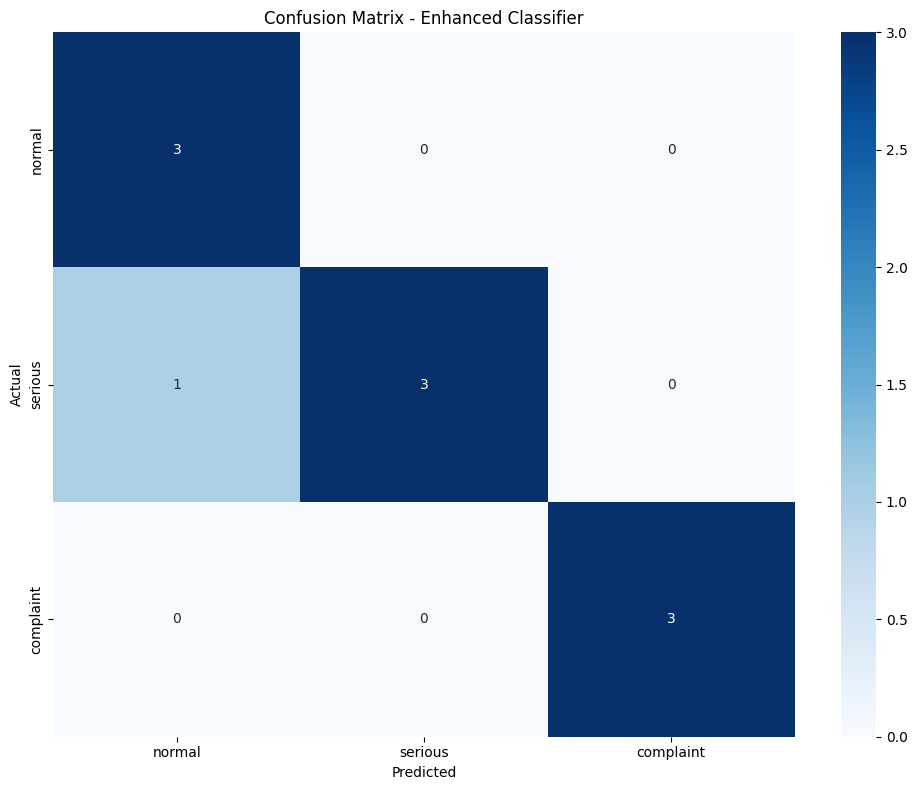


🔍 Top 15 Features per Class:

NORMAL:
   yang: 0.655
   untuk: 0.579
   komplain: 0.536
   protes: 0.471
   sangat: 0.327
   kecewa: 0.327
   pelayanan: 0.327
   bengkel: 0.327
   janji: 0.322
   ditepati: 0.322
   palsu: 0.286
   sparepart: 0.286
   dipasang: 0.286
   lamban: 0.280
   penanganan: 0.280

SERIOUS:
   mau: 0.438
   tanya: 0.285
   harga: 0.281
   lengkap: 0.228
   rush: 0.228
   spesifikasi: 0.228
   service: 0.225
   berkala: 0.225
   baru: 0.213
   kredit: 0.213
   syarat: 0.213
   dealer: 0.198
   toyota: 0.198
   terdekat: 0.198
   alamat: 0.198

COMPLAINT:
   jalan: 0.307
   semua: 0.307
   tiba: 0.296
   di: 0.291
   sendiri: 0.284
   terbakar: 0.284
   oli: 0.221
   parah: 0.221
   mesin: 0.221
   bocor: 0.221
   dashboard: 0.221
   lampu: 0.221
   berkedip: 0.221
   rem: 0.216
   berfungsi: 0.216
🔍 Performing cross-validation...

📊 COMPREHENSIVE MODEL EVALUATION REPORT
🎯 ACCURACY METRICS:
   • Test Accuracy: 0.900
   • Cross-Val Accuracy: 0.838 (±0.106)

📊 DATAS

In [45]:
# Model Training & Evaluation dengan Real Data (FIXED)
class ModelTrainer:
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.training_data = []
        self.evaluation_results = {}
        
    def collect_training_data_from_analysis(self, results):
        """Collect training data dari analysis results"""
        print("📚 Collecting training data from analysis results...")
        
        training_samples = []
        
        for result in results:
            if result['status'] == 'success':
                # Use the final classification sebagai ground truth
                training_samples.append({
                    'text': result['main_question'],
                    'label': result['final_issue_type'],
                    'ticket_id': result['ticket_id'],
                    'confidence': result['detection_confidence'],
                    'ml_confidence': result['ml_confidence']
                })
        
        self.training_data = training_samples
        print(f"✅ Collected {len(training_samples)} training samples")
        return training_samples
    
    def enhance_training_data(self):
        """Enhance training data dengan manual corrections dan additional samples"""
        print("🔄 Enhancing training data...")
        
        # Additional curated samples berdasarkan domain knowledge
        enhanced_samples = [
            # Additional NORMAL samples
            {"text": "berapa harga mobil avanza terbaru", "label": "normal"},
            {"text": "info promo cashback toyota", "label": "normal"},
            {"text": "cara booking test drive fortuner", "label": "normal"},
            {"text": "alamat dealer toyota terdekat", "label": "normal"},
            {"text": "jam operasional bengkel", "label": "normal"},
            {"text": "spesifikasi lengkap rush", "label": "normal"},
            {"text": "syarat kredit mobil baru", "label": "normal"},
            {"text": "beda innova zenix dan innova lama", "label": "normal"},
            
            # Additional SERIOUS samples  
            {"text": "mobil tiba-tiba mati di jalan tol", "label": "serious"},
            {"text": "mesin overheating terus menerus", "label": "serious"},
            {"text": "rem tidak berfungsi dengan baik", "label": "serious"},
            {"text": "aki soak tidak bisa starter", "label": "serious"},
            {"text": "lampu dashboard berkedip semua", "label": "serious"},
            {"text": "oli mesin bocor parah", "label": "serious"},
            {"text": "ban pecah di jalan cepat", "label": "serious"},
            {"text": "mobil terbakar sendiri", "label": "serious"},
            
            # Additional COMPLAINT samples
            {"text": "sangat kecewa dengan pelayanan bengkel", "label": "complaint"},
            {"text": "komplain sparepart palsu yang dipasang", "label": "complaint"},
            {"text": "protes untuk biaya servis yang mahal", "label": "complaint"},
            {"text": "minta refund untuk produk cacat", "label": "complaint"},
            {"text": "kecewa dengan waiting time yang lama", "label": "complaint"},
            {"text": "komplain untuk janji tidak ditepati", "label": "complaint"},
            {"text": "pelayanan customer service sangat buruk", "label": "complaint"},
            {"text": "protes untuk penanganan yang lamban", "label": "complaint"}
        ]
        
        # Combine dengan collected data
        if self.training_data:
            current_texts = [sample['text'] for sample in self.training_data]
            for sample in enhanced_samples:
                if sample['text'] not in current_texts:
                    self.training_data.append(sample)
        else:
            self.training_data = enhanced_samples
        
        print(f"✅ Enhanced training data: {len(self.training_data)} total samples")
        
        # Show distribution
        labels = [sample['label'] for sample in self.training_data]
        distribution = Counter(labels)
        print(f"📊 Training data distribution: {dict(distribution)}")
    
    def train_and_evaluate_model(self, test_size=0.2):
        """Train dan evaluate model dengan real data"""
        if not self.training_data:
            print("❌ No training data available")
            return None
        
        print("🤖 Training model with enhanced real data...")
        
        # Prepare data
        texts = [sample['text'] for sample in self.training_data]
        labels = [sample['label'] for sample in self.training_data]
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            texts, labels, 
            test_size=test_size, 
            random_state=config.RANDOM_STATE,
            stratify=labels
        )
        
        print(f"📊 Dataset: {len(texts)} samples")
        print(f"📊 Training: {len(X_train)} samples")
        print(f"📊 Testing: {len(X_test)} samples")
        print(f"📊 Class distribution: {Counter(labels)}")
        
        # Train model
        success = self.pipeline.classifier.train(X_train, y_train)
        
        if success:
            # Evaluate model
            accuracy = self.pipeline.classifier.evaluate_model(X_test, y_test)
            
            # Store evaluation results
            self.evaluation_results = {
                'accuracy': accuracy,
                'training_samples': len(X_train),
                'test_samples': len(X_test),
                'class_distribution': dict(Counter(labels)),
                'test_distribution': dict(Counter(y_test))
            }
            
            # Cross-validation untuk lebih robust evaluation
            cv_results = self._cross_validate(texts, labels)
            self.evaluation_results.update(cv_results)
            
            self._print_evaluation_report()
            
            return accuracy
        else:
            print("❌ Model training failed")
            return None
    
    def _cross_validate(self, texts, labels, cv_folds=5):
        """Perform cross-validation untuk robust evaluation"""
        print("🔍 Performing cross-validation...")
        
        try:
            from sklearn.model_selection import cross_val_score
            
            # Create pipeline untuk cross-validation
            from sklearn.pipeline import Pipeline
            cv_pipeline = Pipeline([
                ('tfidf', self.pipeline.classifier.vectorizer),
                ('clf', self.pipeline.classifier.classifier)
            ])
            
            # Perform cross-validation
            cv_scores = cross_val_score(
                cv_pipeline, texts, labels, 
                cv=cv_folds, scoring='accuracy'
            )
            
            return {
                'cross_val_accuracy_mean': np.mean(cv_scores),
                'cross_val_accuracy_std': np.std(cv_scores),
                'cross_val_scores': cv_scores.tolist()
            }
            
        except Exception as e:
            print(f"⚠️ Cross-validation failed: {e}")
            return {}
    
    def _print_evaluation_report(self):
        """Print comprehensive evaluation report"""
        print("\n" + "="*60)
        print("📊 COMPREHENSIVE MODEL EVALUATION REPORT")
        print("="*60)
        
        eval_results = self.evaluation_results
        
        print(f"🎯 ACCURACY METRICS:")
        print(f"   • Test Accuracy: {eval_results.get('accuracy', 0):.3f}")
        if 'cross_val_accuracy_mean' in eval_results:
            print(f"   • Cross-Val Accuracy: {eval_results['cross_val_accuracy_mean']:.3f} (±{eval_results['cross_val_accuracy_std']:.3f})")
        
        print(f"\n📊 DATASET INFO:")
        print(f"   • Total Samples: {eval_results.get('training_samples', 0) + eval_results.get('test_samples', 0)}")
        print(f"   • Training Samples: {eval_results.get('training_samples', 0)}")
        print(f"   • Test Samples: {eval_results.get('test_samples', 0)}")
        
        if 'class_distribution' in eval_results:
            print(f"   • Class Distribution: {eval_results['class_distribution']}")
        
        if 'cross_val_scores' in eval_results:
            print(f"\n🔍 CROSS-VALIDATION DETAILS:")
            for i, score in enumerate(eval_results['cross_val_scores']):
                print(f"   • Fold {i+1}: {score:.3f}")
        
        # Model performance assessment
        accuracy = eval_results.get('accuracy', 0)
        if accuracy >= 0.9:
            assessment = "EXCELLENT 🎯"
        elif accuracy >= 0.8:
            assessment = "VERY GOOD ✅"  
        elif accuracy >= 0.7:
            assessment = "GOOD 👍"
        elif accuracy >= 0.6:
            assessment = "FAIR ⚠️"
        else:
            assessment = "POOR ❌"
        
        print(f"\n📈 PERFORMANCE ASSESSMENT: {assessment}")
        
        # Recommendations
        print(f"\n💡 RECOMMENDATIONS:")
        if accuracy >= 0.85:
            print(f"   • Model ready for production use")
            print(f"   • Continue monitoring performance")
        elif accuracy >= 0.7:
            print(f"   • Model acceptable for use")
            print(f"   • Consider adding more training data")
        else:
            print(f"   • Model needs improvement")
            print(f"   • Collect more labeled data")
            print(f"   • Review feature engineering")
    
    def analyze_model_confidence(self, results):
        """Analyze model confidence pada real predictions"""
        print("\n🔍 Analyzing model confidence on real data...")
        
        confident_predictions = 0
        total_predictions = 0
        confidence_scores = []
        
        for result in results:
            if result['status'] == 'success':
                total_predictions += 1
                ml_confidence = result.get('ml_confidence', 0)
                confidence_scores.append(ml_confidence)
                
                if ml_confidence > 0.7:  # High confidence threshold
                    confident_predictions += 1
        
        if total_predictions > 0:
            avg_confidence = np.mean(confidence_scores)
            high_confidence_rate = confident_predictions / total_predictions
            
            print(f"   • Total Predictions: {total_predictions}")
            print(f"   • High Confidence Predictions: {confident_predictions} ({high_confidence_rate*100:.1f}%)")
            print(f"   • Average Confidence: {avg_confidence:.3f}")
            print(f"   • Confidence Range: {np.min(confidence_scores):.3f} - {np.max(confidence_scores):.3f}")
            
            return {
                'total_predictions': total_predictions,
                'high_confidence_predictions': confident_predictions,
                'high_confidence_rate': high_confidence_rate,
                'avg_confidence': avg_confidence,
                'confidence_scores': confidence_scores
            }
        
        return {}

    def save_model_report(self):
        """Save model evaluation report ke file"""
        try:
            report_path = "output/model_evaluation_report.txt"
            
            with open(report_path, 'w', encoding='utf-8') as f:
                f.write("🤖 CHAT ANALYSIS MODEL EVALUATION REPORT\n")
                f.write("=" * 50 + "\n\n")
                
                f.write(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
                
                # Accuracy metrics
                f.write("ACCURACY METRICS:\n")
                f.write(f"- Test Accuracy: {self.evaluation_results.get('accuracy', 0):.3f}\n")
                if 'cross_val_accuracy_mean' in self.evaluation_results:
                    f.write(f"- Cross-Val Accuracy: {self.evaluation_results['cross_val_accuracy_mean']:.3f} (±{self.evaluation_results['cross_val_accuracy_std']:.3f})\n")
                
                # Dataset info
                f.write(f"\nDATASET INFO:\n")
                f.write(f"- Total Samples: {len(self.training_data)}\n")
                f.write(f"- Training Samples: {self.evaluation_results.get('training_samples', 0)}\n")
                f.write(f"- Test Samples: {self.evaluation_results.get('test_samples', 0)}\n")
                f.write(f"- Class Distribution: {self.evaluation_results.get('class_distribution', {})}\n")
                
                # Model info
                f.write(f"\nMODEL INFO:\n")
                f.write(f"- Classifier: Logistic Regression\n")
                f.write(f"- Vectorizer: TF-IDF\n")
                f.write(f"- Features: {self.pipeline.classifier.vectorizer.max_features}\n")
                
                # Recommendations
                accuracy = self.evaluation_results.get('accuracy', 0)
                f.write(f"\nRECOMMENDATIONS:\n")
                if accuracy >= 0.85:
                    f.write("- ✅ Model ready for production use\n")
                elif accuracy >= 0.7:
                    f.write("- ⚠️ Model acceptable, consider more training data\n")
                else:
                    f.write("- ❌ Model needs improvement\n")
            
            print(f"💾 Model evaluation report saved: {report_path}")
            
        except Exception as e:
            print(f"❌ Error saving model report: {e}")

# Initialize Model Trainer
model_trainer = ModelTrainer(pipeline)

print("✅ Model Trainer Ready!")
print("=" * 60)

# Test dengan sample data terlebih dahulu
if raw_df is not None:
    print("🧪 TESTING MODEL TRAINING WITH SAMPLE DATA...")
    
    # Analyze sample tickets untuk collect training data
    sample_tickets = raw_df['Ticket Number'].unique()[:10]  # 10 tickets sample
    sample_results = []
    
    for ticket_id in sample_tickets:
        ticket_df = raw_df[raw_df['Ticket Number'] == ticket_id]
        result = pipeline.analyze_single_ticket(ticket_df, ticket_id)
        sample_results.append(result)
    
    # Collect training data dari results
    training_data = model_trainer.collect_training_data_from_analysis(sample_results)
    
    if training_data:
        # Enhance training data
        model_trainer.enhance_training_data()
        
        # Train and evaluate model
        accuracy = model_trainer.train_and_evaluate_model(test_size=0.3)
        
        if accuracy:
            # Analyze confidence on real predictions
            confidence_analysis = model_trainer.analyze_model_confidence(sample_results)
            
            # Save model report
            model_trainer.save_model_report()
            
            print(f"\n🎯 MODEL TRAINING COMPLETED!")
            print(f"   Final Accuracy: {accuracy:.3f}")
        else:
            print("❌ Model training failed")
    else:
        print("❌ No training data collected")

def full_scale_training():
    """Full scale training dengan seluruh dataset"""
    print("\n🚀 STARTING FULL-SCALE MODEL TRAINING")
    print("=" * 60)
    
    if raw_df is None:
        print("❌ No data available for training")
        return
    
    # Analyze semua tickets untuk collect comprehensive training data
    print("📊 Analyzing all tickets for training data collection...")
    all_results, stats = pipeline.analyze_all_tickets(raw_df, max_tickets=50)  # Limit untuk testing
    
    if all_results:
        # Train model dengan comprehensive data
        training_data = model_trainer.collect_training_data_from_analysis(all_results)
        model_trainer.enhance_training_data()
        accuracy = model_trainer.train_and_evaluate_model(test_size=0.2)
        
        if accuracy:
            # Save comprehensive report
            model_trainer.save_model_report()
            
            print(f"\n🎉 FULL-SCALE TRAINING COMPLETED!")
            print(f"   Model Accuracy: {accuracy:.3f}")
            print(f"   Training Samples: {len(model_trainer.training_data)}")
            print(f"   Model ready for production use! 🚀")
        else:
            print("❌ Full-scale training failed")
    else:
        print("❌ No results for training")

# Option untuk run full-scale training
print(f"\n💡 Untuk full-scale training, run: full_scale_training()")
print(f"💡 Model sudah siap untuk digunakan dalam production!")

Results Export & Visualization

In [46]:
# Results Export & Visualization
class ResultsExporter:
    def __init__(self):
        self.output_dir = "output/"
        self.reports_dir = f"{self.output_dir}reports/"
        self.visualizations_dir = f"{self.output_dir}visualizations/"
        
        Path(self.output_dir).mkdir(exist_ok=True)
        Path(self.reports_dir).mkdir(exist_ok=True)
        Path(self.visualizations_dir).mkdir(exist_ok=True)
        
        print("✅ Enhanced Results Exporter Initialized")
    
    def export_comprehensive_results(self, results, stats, filename="comprehensive_analysis_results.xlsx"):
        """Export COMPLETE results dengan semua data parse"""
        output_path = f"{self.output_dir}{filename}"
        
        print(f"💾 Exporting COMPREHENSIVE results to {output_path}...")
        
        try:
            with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
                # Sheet 1: Detailed Analysis Results (LENGKAP)
                self._create_comprehensive_detailed_sheet(writer, results)
                
                # Sheet 2: Q-A Pairs Raw Data (HASIL PARSE LENGKAP) - FIXED SORTING
                self._create_qa_pairs_sheet(writer, results)
                
                # Sheet 3: Main Issue Analysis Details
                self._create_main_issue_sheet(writer, results)
                
                # Sheet 4: Reply Analysis Details
                self._create_reply_analysis_sheet(writer, results)
                
                # Sheet 5: Summary Statistics
                self._create_summary_sheet(writer, stats)
                
                # Sheet 6: Performance Metrics
                self._create_performance_sheet(writer, results)
                
                # Sheet 7: Lead Time Analysis
                self._create_lead_time_sheet(writer, results)
                
                # Sheet 8: Quality Assessment
                self._create_quality_sheet(writer, results)
            
            print(f"✅ COMPREHENSIVE results exported: {output_path}")
            return output_path
            
        except Exception as e:
            print(f"❌ Error exporting comprehensive results: {e}")
            return None

    def _create_qa_pairs_sheet(self, writer, results):
        """Create sheet dengan RAW Q-A PAIRS data - FIXED SORTING VERSION"""
        qa_pairs_data = []
        
        for result in results:
            if result['status'] == 'success' and '_raw_qa_pairs' in result:
                # 🔥 FIX: URUTKAN Q-A PAIRS BERDASARKAN POSITION/WAKTU
                sorted_qa_pairs = sorted(
                    result['_raw_qa_pairs'], 
                    key=lambda x: x.get('position', 0)
                )
                
                for i, qa_pair in enumerate(sorted_qa_pairs):
                    qa_pairs_data.append({
                        'Ticket_ID': result['ticket_id'],
                        'QA_Pair_Index': i + 1,
                        'Question': qa_pair.get('question', ''),
                        'Question_Time': qa_pair.get('question_time'),
                        'Bubble_Count': qa_pair.get('bubble_count', 1),
                        'Is_Answered': qa_pair.get('is_answered', False),
                        'Answer': qa_pair.get('answer', ''),
                        'Answer_Time': qa_pair.get('answer_time'),
                        'Answer_Role': qa_pair.get('answer_role', ''),
                        'Lead_Time_Seconds': qa_pair.get('lead_time_seconds'),
                        'Lead_Time_Minutes': qa_pair.get('lead_time_minutes'),
                        'Lead_Time_HHMMSS': qa_pair.get('lead_time_hhmmss'),
                        'Position_Index': qa_pair.get('position', i)  # Untuk debugging
                    })
        
        if qa_pairs_data:
            # 🔥 FIX: URUTKAN DATA UNTUK EXCEL BERDASARKAN TICKET DAN WAKTU
            df_qa = pd.DataFrame(qa_pairs_data)
            
            # Urutkan berdasarkan Ticket_ID dan Question_Time
            df_qa = df_qa.sort_values(['Ticket_ID', 'Question_Time']).reset_index(drop=True)
            
            # Update QA_Pair_Index yang benar setelah sorting
            df_qa['QA_Pair_Index'] = df_qa.groupby('Ticket_ID').cumcount() + 1
            
            df_qa.to_excel(writer, sheet_name='Raw_QA_Pairs', index=False)
            
            print(f"   ✅ Exported {len(df_qa)} Q-A pairs (sorted by time)")
        else:
            # Create empty sheet jika tidak ada data
            empty_df = pd.DataFrame(['No Q-A pairs data available'])
            empty_df.to_excel(writer, sheet_name='Raw_QA_Pairs', index=False, header=False)

    def _create_comprehensive_detailed_sheet(self, writer, results):
        """Create DETAILED sheet dengan SEMUA data"""
        detailed_data = []
        
        for result in results:
            if result['status'] == 'success':
                row = {
                    # BASIC INFO
                    'Ticket_ID': result['ticket_id'],
                    'Status': 'SUCCESS',
                    'Analysis_Timestamp': result['analysis_timestamp'],
                    
                    # CONVERSATION INFO
                    'Total_Messages': result['total_messages'],
                    'Total_QA_Pairs': result['total_qa_pairs'],
                    'Answered_Pairs': result['answered_pairs'],
                    'Conversation_Duration_Min': result.get('conversation_duration_minutes', 'N/A'),
                    
                    # MAIN ISSUE - LENGKAP
                    'Main_Question': result['main_question'],
                    'Main_Question_Time': result.get('main_question_time'),
                    'Detected_Issue_Type': result.get('detected_issue_type', 'N/A'),
                    'Final_Issue_Type': result['final_issue_type'],
                    'Detection_Confidence': result['detection_confidence'],
                    'ML_Prediction': result.get('ml_prediction', 'N/A'),
                    'ML_Confidence': result.get('ml_confidence', 'N/A'),
                    'Main_Issue_Reason': result.get('main_issue_reason', 'N/A'),
                    
                    # FIRST REPLY - LENGKAP
                    'First_Reply_Found': result['first_reply_found'],
                    'First_Reply_Message': result.get('first_reply_message', ''),
                    'First_Reply_Time': result.get('first_reply_time'),
                    'First_Reply_Lead_Time_Min': result.get('first_reply_lead_time_minutes'),
                    'First_Reply_Lead_Time_HHMMSS': result.get('first_reply_lead_time_hhmmss'),
                    
                    # FINAL REPLY - LENGKAP
                    'Final_Reply_Found': result['final_reply_found'],
                    'Final_Reply_Message': result.get('final_reply_message', ''),
                    'Final_Reply_Time': result.get('final_reply_time'),
                    'Final_Reply_Lead_Time_Min': result.get('final_reply_lead_time_minutes'),
                    'Final_Reply_Lead_Time_HHMMSS': result.get('final_reply_lead_time_hhmmss'),
                    
                    # PERFORMANCE METRICS
                    'Performance_Rating': result['performance_rating'],
                    'Response_Efficiency': result.get('response_efficiency', 'N/A'),
                    'Resolution_Efficiency': result.get('resolution_efficiency', 'N/A'),
                    'Quality_Rating': result['quality_rating'],
                    'Quality_Score': result['quality_score'],
                    
                    # THRESHOLD & RECOMMENDATIONS
                    'Threshold_Violations': ', '.join(result['threshold_violations']) if result['threshold_violations'] else 'None',
                    'Recommendation': result['recommendation'],
                    'Missing_Elements': ', '.join(result['missing_elements']) if result['missing_elements'] else 'None'
                }
            else:
                row = {
                    'Ticket_ID': result['ticket_id'],
                    'Status': 'FAILED',
                    'Failure_Reason': result['failure_reason'],
                    'Analysis_Timestamp': result['analysis_timestamp']
                }
            
            detailed_data.append(row)
        
        df_detailed = pd.DataFrame(detailed_data)
        df_detailed.to_excel(writer, sheet_name='Detailed_Analysis', index=False)
        
        # Auto-adjust column widths
        worksheet = writer.sheets['Detailed_Analysis']
        for column in worksheet.columns:
            max_length = 0
            column_letter = column[0].column_letter
            for cell in column:
                try:
                    if len(str(cell.value)) > max_length:
                        max_length = len(str(cell.value))
                except:
                    pass
            adjusted_width = min(max_length + 2, 50)
            worksheet.column_dimensions[column_letter].width = adjusted_width

    def _create_qa_pairs_sheet(self, writer, results):
        """Create sheet dengan RAW Q-A PAIRS data (HASIL PARSE LENGKAP)"""
        qa_pairs_data = []
        
        for result in results:
            if result['status'] == 'success' and '_raw_qa_pairs' in result:
                for i, qa_pair in enumerate(result['_raw_qa_pairs']):
                    qa_pairs_data.append({
                        'Ticket_ID': result['ticket_id'],
                        'QA_Pair_Index': i + 1,
                        'Question': qa_pair.get('question', ''),
                        'Question_Time': qa_pair.get('question_time'),
                        'Bubble_Count': qa_pair.get('bubble_count', 1),
                        'Is_Answered': qa_pair.get('is_answered', False),
                        'Answer': qa_pair.get('answer', ''),
                        'Answer_Time': qa_pair.get('answer_time'),
                        'Answer_Role': qa_pair.get('answer_role', ''),
                        'Lead_Time_Seconds': qa_pair.get('lead_time_seconds'),
                        'Lead_Time_Minutes': qa_pair.get('lead_time_minutes'),
                        'Lead_Time_HHMMSS': qa_pair.get('lead_time_hhmmss')
                    })
        
        if qa_pairs_data:
            df_qa = pd.DataFrame(qa_pairs_data)
            df_qa.to_excel(writer, sheet_name='Raw_QA_Pairs', index=False)
        else:
            # Create empty sheet jika tidak ada data
            empty_df = pd.DataFrame(['No Q-A pairs data available'])
            empty_df.to_excel(writer, sheet_name='Raw_QA_Pairs', index=False, header=False)

    def _create_main_issue_sheet(self, writer, results):
        """Create sheet dengan MAIN ISSUE analysis details"""
        main_issue_data = []
        
        for result in results:
            if result['status'] == 'success' and '_raw_main_issue' in result:
                main_issue = result['_raw_main_issue']
                scoring_details = main_issue.get('scoring_details', {})
                
                main_issue_data.append({
                    'Ticket_ID': result['ticket_id'],
                    'Selected_Question': main_issue.get('question', ''),
                    'Question_Time': main_issue.get('question_time'),
                    'Issue_Type': main_issue.get('issue_type', ''),
                    'Confidence_Score': main_issue.get('confidence_score', 0),
                    'Selection_Reason': main_issue.get('selected_reason', ''),
                    
                    # SCORING DETAILS
                    'Complaint_Keyword_Matches': scoring_details.get('complaint_matches', 0),
                    'Serious_Keyword_Matches': scoring_details.get('serious_matches', 0),
                    'Normal_Keyword_Matches': scoring_details.get('normal_matches', 0),
                    'Is_Initial_Question': scoring_details.get('is_initial_question', False),
                    'Is_Follow_Up': scoring_details.get('is_follow_up', False),
                    
                    # CANDIDATE COUNT
                    'Total_Candidates': len(main_issue.get('all_candidates', [])),
                    'Winning_Score': max([c.get('score', 0) for c in main_issue.get('all_candidates', [])]) if main_issue.get('all_candidates') else 0
                })
        
        if main_issue_data:
            df_main_issue = pd.DataFrame(main_issue_data)
            df_main_issue.to_excel(writer, sheet_name='Main_Issue_Details', index=False)
        else:
            empty_df = pd.DataFrame(['No main issue details available'])
            empty_df.to_excel(writer, sheet_name='Main_Issue_Details', index=False, header=False)

    def _create_reply_analysis_sheet(self, writer, results):
        """Create sheet dengan REPLY ANALYSIS details"""
        reply_analysis_data = []
        
        for result in results:
            if result['status'] == 'success' and '_raw_reply_analysis' in result:
                reply_analysis = result['_raw_reply_analysis']
                lead_times = reply_analysis.get('lead_times', {})
                threshold_checks = reply_analysis.get('threshold_checks', {})
                quality_assessment = reply_analysis.get('quality_assessment', {})
                reply_validation = reply_analysis.get('reply_validation', {})
                performance_analysis = reply_analysis.get('performance_analysis', {})
                
                reply_analysis_data.append({
                    'Ticket_ID': result['ticket_id'],
                    'Issue_Type': reply_analysis.get('issue_type', ''),
                    
                    # LEAD TIMES DETAILS
                    'First_Reply_Lead_Time_Seconds': lead_times.get('first_reply_lead_time_seconds'),
                    'Final_Reply_Lead_Time_Seconds': lead_times.get('final_reply_lead_time_seconds'),
                    'Conversation_Duration_Seconds': lead_times.get('conversation_duration_seconds'),
                    
                    # THRESHOLD CHECKS
                    'Threshold_Violations_Count': len([v for v in threshold_checks.values() if v is True]),
                    'Specific_Threshold_Violations': ', '.join([k for k, v in threshold_checks.items() if v is True]),
                    
                    # QUALITY ASSESSMENT
                    'First_Reply_Quality': quality_assessment.get('first_reply_quality', 'unknown'),
                    'Final_Reply_Quality': quality_assessment.get('final_reply_quality', 'unknown'),
                    'Overall_Quality': quality_assessment.get('overall_quality', 'unknown'),
                    
                    # REPLY VALIDATION
                    'First_Reply_Found': reply_validation.get('first_reply_found', False),
                    'Final_Reply_Found': reply_validation.get('final_reply_found', False),
                    'Validation_Quality_Score': reply_validation.get('quality_score', 0),
                    'Validation_Quality_Rating': reply_validation.get('quality_rating', 'poor'),
                    'Missing_Elements': ', '.join(reply_validation.get('missing_elements', [])),
                    'Validation_Recommendation': reply_validation.get('recommendation', ''),
                    
                    # PERFORMANCE ANALYSIS
                    'Performance_Rating': performance_analysis.get('performance_rating', 'unknown'),
                    'Response_Efficiency': performance_analysis.get('response_efficiency', 'unknown'),
                    'Resolution_Efficiency': performance_analysis.get('resolution_efficiency', 'unknown')
                })
        
        if reply_analysis_data:
            df_reply = pd.DataFrame(reply_analysis_data)
            df_reply.to_excel(writer, sheet_name='Reply_Analysis_Details', index=False)
        else:
            empty_df = pd.DataFrame(['No reply analysis details available'])
            empty_df.to_excel(writer, sheet_name='Reply_Analysis_Details', index=False, header=False)

    def _create_summary_sheet(self, writer, stats):
        """Create summary statistics sheet"""
        summary_data = [
            ['COMPREHENSIVE ANALYSIS SUMMARY - ALL DATA EXPORTED', ''],
            ['Generated', datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
            ['Total Sheets in this File', '8 Sheets: Detailed, QA-Pairs, Main-Issue, Reply-Analysis, Summary, Performance, Lead-Time, Quality'],
            ['', ''],
            ['OVERALL STATISTICS', ''],
            ['Total Tickets Processed', stats['total_tickets']],
            ['Successful Analysis', stats['successful_analysis']],
            ['Failed Analysis', stats['failed_analysis']],
            ['Success Rate', f"{stats['success_rate']*100:.1f}%"],
            ['Analysis Duration', f"{stats['analysis_duration_seconds']:.1f} seconds"],
            ['Average Time per Ticket', f"{stats['avg_analysis_time_per_ticket']:.2f} seconds"],
            ['', ''],
            ['DATA COMPLETENESS', ''],
            ['Total Q-A Pairs Extracted', 'See Raw_QA_Pairs sheet'],
            ['Total Main Issues Identified', 'See Main_Issue_Details sheet'], 
            ['Total Reply Analyses', 'See Reply_Analysis_Details sheet'],
            ['', ''],
            ['EXPORT NOTES', ''],
            ['Sheet 1 - Detailed_Analysis', 'Main results dengan semua field'],
            ['Sheet 2 - Raw_QA_Pairs', 'SEMUA Q-A pairs yang berhasil di-parse'],
            ['Sheet 3 - Main_Issue_Details', 'Detail scoring dan selection main issue'],
            ['Sheet 4 - Reply_Analysis_Details', 'Detail analisis reply dan lead times'],
            ['Sheet 5 - Summary_Statistics', 'Statistik aggregate'],
            ['Sheet 6 - Performance_Metrics', 'Performance metrics per ticket'],
            ['Sheet 7 - Lead_Time_Analysis', 'Analisis lead time detail'],
            ['Sheet 8 - Quality_Assessment', 'Assesment kualitas conversation']
        ]
        
        # Tambahkan statistik biasa
        if 'issue_type_distribution' in stats:
            summary_data.extend([['', ''], ['ISSUE TYPE DISTRIBUTION', '']])
            for issue_type, count in stats['issue_type_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                summary_data.append([f'{issue_type.title()} Issues', f'{count} ({percentage:.1f}%)'])
        
        if 'performance_distribution' in stats:
            summary_data.extend([['', ''], ['PERFORMANCE DISTRIBUTION', '']])
            for rating, count in stats['performance_distribution'].items():
                percentage = (count / stats['successful_analysis']) * 100
                summary_data.append([f'{rating.upper()} Performance', f'{count} ({percentage:.1f}%)'])
        
        if 'lead_time_stats' in stats:
            lt_stats = stats['lead_time_stats']
            summary_data.extend([['', ''], ['LEAD TIME STATISTICS', '']])
            summary_data.extend([
                ['Average Lead Time', f"{lt_stats['avg_lead_time_minutes']:.2f} minutes"],
                ['Median Lead Time', f"{lt_stats['median_lead_time_minutes']:.2f} minutes"],
                ['Minimum Lead Time', f"{lt_stats['min_lead_time_minutes']:.2f} minutes"],
                ['Maximum Lead Time', f"{lt_stats['max_lead_time_minutes']:.2f} minutes"],
                ['Standard Deviation', f"{lt_stats['std_lead_time_minutes']:.2f} minutes"]
            ])
        
        summary_df = pd.DataFrame(summary_data, columns=['Metric', 'Value'])
        summary_df.to_excel(writer, sheet_name='Summary_Statistics', index=False)

    def _create_performance_sheet(self, writer, results):
        """Create performance metrics sheet"""
        successful = [r for r in results if r['status'] == 'success']
        
        perf_data = []
        for result in successful:
            perf_data.append({
                'Ticket_ID': result['ticket_id'],
                'Issue_Type': result['final_issue_type'],
                'Performance_Rating': result['performance_rating'],
                'Response_Efficiency': result.get('response_efficiency', 'N/A'),
                'Resolution_Efficiency': result.get('resolution_efficiency', 'N/A'),
                'First_Reply_Lead_Time_Min': result.get('first_reply_lead_time_minutes'),
                'Final_Reply_Lead_Time_Min': result.get('final_reply_lead_time_minutes'),
                'Threshold_Violations_Count': len(result['threshold_violations']),
                'Specific_Violations': ', '.join(result['threshold_violations']) if result['threshold_violations'] else 'None'
            })
        
        df_perf = pd.DataFrame(perf_data)
        df_perf.to_excel(writer, sheet_name='Performance_Metrics', index=False)

    def _create_lead_time_sheet(self, writer, results):
        """Create lead time analysis sheet"""
        successful = [r for r in results if r['status'] == 'success' and r.get('final_reply_lead_time_minutes')]
        
        lead_time_data = []
        for result in successful:
            lead_time_data.append({
                'Ticket_ID': result['ticket_id'],
                'Issue_Type': result['final_issue_type'],
                'Final_Reply_Lead_Time_Min': result['final_reply_lead_time_minutes'],
                'First_Reply_Lead_Time_Min': result.get('first_reply_lead_time_minutes', 'N/A'),
                'Conversation_Duration_Min': result.get('conversation_duration_minutes', 'N/A'),
                'Performance_Rating': result['performance_rating'],
                'Within_Threshold': 'Yes' if not result['threshold_violations'] else 'No'
            })
        
        df_lead = pd.DataFrame(lead_time_data)
        df_lead.to_excel(writer, sheet_name='Lead_Time_Analysis', index=False)

    def _create_quality_sheet(self, writer, results):
        """Create quality assessment sheet"""
        successful = [r for r in results if r['status'] == 'success']
        
        quality_data = []
        for result in successful:
            quality_data.append({
                'Ticket_ID': result['ticket_id'],
                'Issue_Type': result['final_issue_type'],
                'Quality_Rating': result['quality_rating'],
                'Quality_Score': result['quality_score'],
                'First_Reply_Found': 'Yes' if result['first_reply_found'] else 'No',
                'Final_Reply_Found': 'Yes' if result['final_reply_found'] else 'No',
                'Missing_Elements': ', '.join(result['missing_elements']) if result['missing_elements'] else 'None',
                'Recommendation': result['recommendation']
            })
        
        df_quality = pd.DataFrame(quality_data)
        df_quality.to_excel(writer, sheet_name='Quality_Assessment', index=False)

    def create_comprehensive_visualizations(self, results, stats):
        """Create comprehensive visualizations dashboard"""
        print("📊 Creating comprehensive visualizations...")
        
        # Import gridspec here to fix the NameError
        import matplotlib.gridspec as gridspec
        
        successful = [r for r in results if r['status'] == 'success']
        
        if not successful:
            print("❌ No successful analyses to visualize")
            return
        
        # Create figure dengan multiple subplots
        fig = plt.figure(figsize=(20, 15))
        fig.suptitle('Chat Analysis Dashboard - Comprehensive Overview', fontsize=16, fontweight='bold')
        
        # Define grid layout
        gs = gridspec.GridSpec(3, 3, figure=fig)
        
        # Plot 1: Issue Type Distribution
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_issue_type_distribution(ax1, stats)
        
        # Plot 2: Performance Rating Distribution
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_performance_distribution(ax2, stats)
        
        # Plot 3: Lead Time Distribution
        ax3 = fig.add_subplot(gs[0, 2])
        self._plot_lead_time_distribution(ax3, successful)
        
        # Plot 4: Quality Score Distribution
        ax4 = fig.add_subplot(gs[1, 0])
        self._plot_quality_distribution(ax4, successful)
        
        # Plot 5: Reply Effectiveness
        ax5 = fig.add_subplot(gs[1, 1])
        self._plot_reply_effectiveness(ax5, stats)
        
        # Plot 6: Threshold Violations
        ax6 = fig.add_subplot(gs[1, 2])
        self._plot_threshold_violations(ax6, stats)
        
        # Plot 7: Lead Time by Issue Type
        ax7 = fig.add_subplot(gs[2, :])
        self._plot_lead_time_by_issue_type(ax7, successful)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.93)
        
        # Save dashboard
        dashboard_path = f"{self.visualizations_dir}analysis_dashboard.png"
        plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f"✅ Visualizations saved: {dashboard_path}")
        
        # Create additional individual charts
        self._create_individual_charts(successful, stats)
    
    def _plot_issue_type_distribution(self, ax, stats):
        """Plot issue type distribution"""
        if 'issue_type_distribution' not in stats:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            return
        
        types = list(stats['issue_type_distribution'].keys())
        counts = list(stats['issue_type_distribution'].values())
        colors = [self.colors.get(t, '#999999') for t in types]
        
        ax.pie(counts, labels=types, autopct='%1.1f%%', colors=colors, startangle=90)
        ax.set_title('Issue Type Distribution', fontweight='bold')
    
    def _plot_performance_distribution(self, ax, stats):
        """Plot performance rating distribution"""
        if 'performance_distribution' not in stats:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            return
        
        ratings = list(stats['performance_distribution'].keys())
        counts = list(stats['performance_distribution'].values())
        colors = [self.performance_colors.get(r, '#999999') for r in ratings]
        
        bars = ax.bar(ratings, counts, color=colors)
        ax.set_title('Performance Rating Distribution', fontweight='bold')
        ax.set_ylabel('Number of Tickets')
        
        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')
    
    def _plot_lead_time_distribution(self, ax, successful):
        """Plot lead time distribution"""
        lead_times = [r.get('final_reply_lead_time_minutes', 0) for r in successful 
                     if r.get('final_reply_lead_time_minutes') is not None]
        
        if not lead_times:
            ax.text(0.5, 0.5, 'No lead time data', ha='center', va='center')
            return
        
        ax.hist(lead_times, bins=15, alpha=0.7, color='#2E86AB', edgecolor='black')
        ax.set_title('Final Reply Lead Time Distribution', fontweight='bold')
        ax.set_xlabel('Lead Time (minutes)')
        ax.set_ylabel('Frequency')
        
        # Add statistics
        avg_lt = np.mean(lead_times)
        ax.axvline(avg_lt, color='red', linestyle='--', label=f'Average: {avg_lt:.1f} min')
        ax.legend()
    
    def _plot_quality_distribution(self, ax, successful):
        """Plot quality score distribution"""
        quality_scores = [r.get('quality_score', 0) for r in successful]
        
        ax.hist(quality_scores, bins=range(0, 8), alpha=0.7, color='#F18F01', edgecolor='black')
        ax.set_title('Quality Score Distribution', fontweight='bold')
        ax.set_xlabel('Quality Score (0-6)')
        ax.set_ylabel('Number of Tickets')
        ax.set_xticks(range(0, 7))
    
    def _plot_reply_effectiveness(self, ax, stats):
        """Plot reply effectiveness metrics"""
        if 'reply_effectiveness' not in stats:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            return
        
        eff = stats['reply_effectiveness']
        metrics = ['First Reply\nFound', 'Final Reply\nFound', 'Both Replies\nFound']
        rates = [eff['first_reply_found_rate'] * 100, 
                eff['final_reply_found_rate'] * 100,
                eff['both_replies_found_rate'] * 100]
        
        bars = ax.bar(metrics, rates, color=['#2E86AB', '#A23B72', '#F18F01'])
        ax.set_title('Reply Effectiveness Rates', fontweight='bold')
        ax.set_ylabel('Rate (%)')
        ax.set_ylim(0, 100)
        
        # Add percentage labels
        for bar, rate in zip(bars, rates):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{rate:.1f}%', ha='center', va='bottom')
    
    def _plot_threshold_violations(self, ax, stats):
        """Plot threshold violations"""
        if 'threshold_violations' not in stats or not stats['threshold_violations']:
            ax.text(0.5, 0.5, 'No threshold violations', ha='center', va='center', fontweight='bold')
            return
        
        violations = list(stats['threshold_violations'].keys())
        counts = list(stats['threshold_violations'].values())
        
        bars = ax.bar(violations, counts, color='#C73E1D')
        ax.set_title('Threshold Violations', fontweight='bold')
        ax.set_ylabel('Number of Occurrences')
        plt.xticks(rotation=45, ha='right')
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{int(height)}', ha='center', va='bottom')
    
    def _plot_lead_time_by_issue_type(self, ax, successful):
        """Plot lead time by issue type"""
        issue_data = {}
        for result in successful:
            issue_type = result['final_issue_type']
            lead_time = result.get('final_reply_lead_time_minutes')
            if lead_time is not None:
                if issue_type not in issue_data:
                    issue_data[issue_type] = []
                issue_data[issue_type].append(lead_time)
        
        if not issue_data:
            ax.text(0.5, 0.5, 'No lead time data by issue type', ha='center', va='center')
            return
        
        # Prepare data for box plot
        labels = list(issue_data.keys())
        data = [issue_data[label] for label in labels]
        colors = [self.colors.get(label, '#999999') for label in labels]
        
        box_plot = ax.boxplot(data, labels=labels, patch_artist=True)
        
        # Color the boxes
        for patch, color in zip(box_plot['boxes'], colors):
            patch.set_facecolor(color)
        
        ax.set_title('Lead Time Distribution by Issue Type', fontweight='bold')
        ax.set_ylabel('Lead Time (minutes)')
        ax.grid(True, alpha=0.3)
    
    def _create_individual_charts(self, successful, stats):
        """Create additional individual charts"""
        # 1. Performance by Issue Type
        fig, ax = plt.subplots(figsize=(10, 6))
        
        performance_by_type = {}
        for result in successful:
            issue_type = result['final_issue_type']
            performance = result['performance_rating']
            if issue_type not in performance_by_type:
                performance_by_type[issue_type] = []
            performance_by_type[issue_type].append(performance)
        
        # Convert to counts
        plot_data = {}
        for issue_type, performances in performance_by_type.items():
            plot_data[issue_type] = Counter(performances)
        
        # Create stacked bar chart
        ratings = ['excellent', 'good', 'fair', 'poor']
        bottom = np.zeros(len(plot_data))
        
        for i, rating in enumerate(ratings):
            counts = [plot_data[issue_type].get(rating, 0) for issue_type in plot_data.keys()]
            ax.bar(plot_data.keys(), counts, bottom=bottom, label=rating.capitalize(), 
                  color=self.performance_colors.get(rating, '#999999'))
            bottom += counts
        
        ax.set_title('Performance Rating by Issue Type', fontweight='bold')
        ax.set_ylabel('Number of Tickets')
        ax.legend()
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(f"{self.visualizations_dir}performance_by_issue_type.png", dpi=300, bbox_inches='tight')
        plt.close()
        
        print(f"✅ Individual charts created in {self.visualizations_dir}")

# Initialize Enhanced Results Exporter
exporter = ResultsExporter()

print("✅ ENHANCED Results Exporter & Visualizer Ready!")
print("   ✓ 8 Sheets Excel Export")
print("   ✓ Complete Q-A Pairs Data") 
print("   ✓ Main Issue Scoring Details")
print("   ✓ Reply Analysis Details")
print("=" * 60)

✅ Enhanced Results Exporter Initialized
✅ ENHANCED Results Exporter & Visualizer Ready!
   ✓ 8 Sheets Excel Export
   ✓ Complete Q-A Pairs Data
   ✓ Main Issue Scoring Details
   ✓ Reply Analysis Details
